# Supervised Learning for HR Separations
## June 10, 2015
<hr>

###Identify the correct working directory for source data
* '/data/discovery/hrsepara/core/'

###Identify the correct working directory for the analysis (both HDFS and LFS)
* '/data/discovery/hrsepara/staging/eda' and '/home/kesj/working/hrsepara/eda/'


In [3]:
coredir = '/data/discovery/hrsepara/core/'
stgdir1 = '/data/discovery/hrsepara/staging/eda'
stgdir1local = '/home/kesj/work/hrsepara/eda'

In [4]:
### load the basic files
import os,subprocess
import pandas as pd
import numpy as np
%matplotlib inline
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
import itertools
from random import random

In [5]:
import seaborn as sns

In [6]:
plt.style.use('ggplot')
os.path.exists(stgdir1local)

True

In [7]:
%cd {stgdir1local}

/home/kesj/work/hrsepara/eda


### Helper Functions Follow
* Most taken from ```bear.py```
* 

In [8]:
# from bear.py 
def impute_categorical(dataframe, variable_list, value_for_missing="Missing",
                       inplace=False):
    """All NaN values in dataframe are replaced with "Missing"
    
    Parameters
    ----------
    dataframe: pandas dataframe
    
    variable_list: list
        A list of all the categorical columns to replace
    
    value_for_missing: string, optional (default="Missing")
    """   
    # Change from list to dictionary where each key is a column and the value
    # is the value_for_missing. Creating this is required. Otherwise all missing
    # values in the entire dataframe would be filled with the value_for_missing
    values=dict(zip(variable_list, [value_for_missing]*len(variable_list)))
    if inplace:
        dataframe.fillna(values, inplace=True)
    else:
        return dataframe.fillna(values)

    
def bin_categorical(X, columns_to_bin="all", min_percent_of_total=0.05, 
                    replacement_value="Other", rows_to_scan=5000, test=False):
    """Any categories that have less than min_percent_of_total are replaced with
    the replacement_value. Works inplace.
    
    Parameters
    ----------
    X: pandas dataframe
    
    columns_to_bin: string or list, optional (default="all")
        If "all", imputes all object columns with missing values. Other 
        strings are interpreted to represent column names and you can 
        pass a list of column names to impute.
    
    min_percent_of_total: float, optional (default=0.05)
        For each category, calculates what percent it makes up of the 
        total. If it is less than or equal to min_percent_of_total, the 
        value is replaced with the replacement_value
        
    replacement_value: string, optional (default="Other")
        Replaces small categories with this value
        
    test: boolean, optional (default=False)
        If True, does not affect the data. Instead prints counts of each
        variable and the percent threshold needed to bin it.
    """
    # Handles convenience args
    if rows_to_scan is None or rows_to_scan == "all":
        rows_to_scan = X.shape[0]
    else:
        if rows_to_scan > X.shape[0]:
            rows_to_scan = X.shape[0]
    
    if columns_to_bin == "all":
        columns_to_bin = [cols for cols in X.columns if X.dtypes[cols]=="object"]
    elif type(columns_to_bin) == str:
        columns_to_bin = [columns_to_bin]
    
    # Keeps track of the values to keep. Values not included are binned.
    # By keeping track of only the values to keep, we only need to scan
    # a small part of the dataset.
    for variable in columns_to_bin:
        counts = X[variable][:rows_to_scan].value_counts()
        variables_to_not_bucket_index = counts > rows_to_scan*min_percent_of_total
        large_counts = counts.index[variables_to_not_bucket_index]       
        if test:
            counts = pd.DataFrame(counts, columns=["counts"])
            counts["percent"] = counts/counts.sum()
            counts["bucketed?"] = -variables_to_not_bucket_index
            counts["cumsum"] = counts["percent"].cumsum()
            print counts
            return counts
        else:
            X.loc[-X[variable].isin(large_counts), variable] = replacement_value

            
# This is to add the categorical variables to the model to help in imputation
def get_number_of_unique_values(X, columns="all", rows_to_scan=10000,
                                objects_only=False, return_series=False,
                                skip_nans=True):
    """Returns a Series with the number of unique values of each object column 
    sorted from least to most.
    
    Parameters
    ----------
    X: pandas df
    
    columns: list or string, optional (default="all")
        Gets unique values for list of columns or a single column.
        If "all" uses all columns.
    
    rows_to_scan: integer or 'all', optional (default=10000)
        If 'all' uses entire df. Else, uses at max rows_to_scan.
    
    objects_only: boolean, optional (default="False")
        If true, only object type columns are analyzed
    
    return_series: boolean, optional (default="False")
        If True, returns Series. If False only prints it.
    """
    if skip_nans:
        print "skip_nans not implemented yet"
    
    if rows_to_scan > X.shape[0] or rows_to_scan == "all":
        rows_to_scan = X.shape[0]
    unique_counts = pd.Series()
    
    if columns == "all":
        columns = X.columns
    elif type(columns) == str:
        columns = [columns]
    
    for variables in columns:
        if not objects_only or X.dtypes[variables]=="object":
            list_of_unique_values = X[variables][:rows_to_scan].unique()
            number_of_unique_values = len(list_of_unique_values)
#             if skip_nans and np.isnan(list_of_unique_values).any():
#                 number_of_unique_values -= 1
            unique_counts[variables] = number_of_unique_values
        
    unique_counts.sort()
    pd.set_option('display.max_rows', len(X))
    print unique_counts
    pd.set_option('display.max_rows', 0)
    
    if return_series:
        return unique_counts

    
def n_valid_rows(n, X):
    """ Return n or len(X), whichever is shorter"""
    if n > X.shape[0]:
        return X.shape[0]
    return n


def transform_categorical(X, y, col_name):
    """
    Returns a dataframe of mappings for categorical variables where
    each category is mapped to the mean response variable.
    """
    temp = pd.DataFrame(pd.crosstab(X[col_name], y).apply(lambda x: x[1]/float(x.sum()), axis=1))
    temp.columns = [str(col_name) + "_num"]
    temp[col_name] = temp.index
    return temp


def add_transformed_categorical(X, y, col_name, drop_original=True):
    """
    Return X where each category in the categorical variables is replaced with
    the mean of the category.
    """
    X = pd.merge(X, transform_categorical(X, y, col_name), how="left", on=col_name)
    if drop_original:
        X.drop([col_name], axis=1, inplace=True)
    return X


def dummy_variables(X, columns_to_dummy, drop_one_column=False, drop_original=True,
                    rows_to_scan=10000, special_column_rules=None, dummy_na=False):
    """ 
    MUCH faster if pandas >= 0.15.0.
    
    Replace categorical columns with dummy variables. Return df and list of base
    variables. 
    
    Parameters
    ----------
    X: pandas dataframe
    
    columns_to_dummy: list
        List of columns to transform
        
    drop_one_column: boolean, optional (default=False)
        Avoid the dummy variable trap in linear models. Should be 
        false for tree-based methods.
    
    drop_original: boolean, optional (default=True)
        Does not include the original categorical columns in the returned
        dataframe.
    
    rows_to_scan: integer, optional (default=10000)
        Finds the most popular column in the first rows_to_scan number
        of rows. Drops this column if drop_one_column is True and if
        special_column_row_rules is blank.
        
    special_column_rules: collection of tuples (default=None)
        Override rows_to_scan option for variables by passing a list or
        dictionary of tuples. The first element of each tuple must be 
        the column name. If the second element is an int, that many
        rows will be scanned and the most popular class will be used.
        If the second element is None, all the rows will be scanned
        and the most popular element will be used. If the second element
        is a string, the dummy variable that corresponds to that string
        name will be dropped.
        
    dummy_na: boolean, optional (default=False)
        Add a column to indicate NaNs, if False NaNs are ignored.
    """
    # Check to see if the newest version of pandas is installed
    if int(pd.version.version.split(".")[1]) >= 15:
        # Make a list of columns to drop for dummies
        if drop_one_column:
            if special_column_rules:
                special_column_rules = dict(special_column_rules)
            else:
                special_column_rules = {}
            base_columns = []
            for col in columns_to_dummy:
                rows = special_column_rules.get(col, rows_to_scan)
                if (rows == "all") or (rows is None):
                    base_columns.append(str(col) + "_" + str(X[col].value_counts().index[0]))
                elif type(rows) == str:
                    base_columns.append(str(col) + "_" + rows)
                else:
                    rows = n_valid_rows(rows, X)-1
                    base_columns.append(str(col) + "_" + str(X.loc[:rows, col].value_counts().index[0]))
            
        # Include dummies in dataframe
        X = pd.get_dummies(X, prefix=columns_to_dummy, dummy_na=dummy_na, columns=columns_to_dummy)    
        
        # Drop most represented variable from each column
        if drop_one_column:
            X.drop(base_columns, axis=1, inplace=True)
            
        # Drop original categorical variables if specified
        if drop_original:
            X.drop(columns_to_dummy, axis=1, inplace=True)
        
        return X, base_columns

    # Older version of pandas
    else:
        listOfDroppedCols = []

        if X.shape[0] < rows_to_scan:
            rows_to_scan = X.shape[0]

        if drop_one_column:
            print "***Base variables***"

        for variable in columns_to_dummy:
            if variable in X.columns:
                dummies = pd.get_dummies(X[variable], prefix=variable)
                X = pd.concat([X, dummies], axis=1)
                if drop_one_column:
                    column_to_drop = "%s_%s" % (variable, 
                                                 X[variable][:rows_to_scan].value_counts().idxmax())
                    print column_to_drop
                    listOfDroppedCols.append(column_to_drop)
                    X.drop([column_to_drop], axis=1, inplace=True)
                if drop_original:
                    X.drop([variable], axis=1, inplace=True)
            else:
                print "%s is not found in dataframe" % variable
        # Replace spaces with underscores in column names
        X.columns = [col.replace(" ", "_") for col in X.columns]
        if drop_one_column:
            print "" # Spacing for other printed modules
        return X, listOfDroppedCols


# Impute numeric with mean
def impute_with_mean(X, columns_to_impute='all',
                     keep_dummies=True,
                     impute_inf=True,
                     rows_to_scan=10000):
    """Use the mean of each variable to impute the data
    
    Parameters
    ----------
    X: pandas dataframe
        The input samples.
        
    columns_to_impute: string or list, optional (default="all")
        If "all", imputes all columns with missing values. Other 
        strings are interpreted to represent column names and you can 
        pass a list of column names to impute.
        
    impute_inf: boolean, optional (default=True)
        If True, also imputes inf values with the mean.
        
    keep_dummies: boolean, optional (default=True)
        For all columns returns a column with a 0 if a valid number and 
        a 1 if it was NaN. Columns have the same name with "_d" 
        appended.
        
    rows_to_scan: integer, optional (default=10000)
        Calculates the mean based off of these many examples. If None,
        uses the entire dataset.
    """
    # Enable flexibility of columns to impute
    if columns_to_impute == "all":
        columns_to_impute = [cols for cols in X.columns if X.dtypes[cols]!="object"]
    elif type(columns_to_impute) == str:
        columns_to_impute = [columns_to_impute]
    
    # Enable rows_to_scan functionality
    if rows_to_scan > X.shape[0] or rows_to_scan is None:
        rows_to_scan = X.shape[0]
    
    values=dict(zip(columns_to_impute, X[columns_to_impute][:rows_to_scan].mean()))

    if keep_dummies:
        dummy_missing = X[columns_to_impute].isnull().astype("int")
        dummy_columns = ["%s_d" % s for s in columns_to_impute]
        dummy_missing.columns = dummy_columns
        X = pd.concat([X.fillna(values), dummy_missing], axis=1)
    else:
        if impute_inf:
            X = X.replace(np.inf, values)
        X = X.fillna(values)
    return X


def hist_of_numeric(X):
    """Histogram of all numeric variables of df"""
    figsize(10,3)
    for col in get_numeric(X):
        print col
        X[col].hist(bins=50)
        show()


def fix_numeric_outliers(X, variable, min_value=None, max_value=None, values_to_skip=["Missing"]):
    """All values outside the range are set to the nearest valid value.
    
    Parameters
    ----------
    X: pandas dataframe
    
    variable: string
        The column name.
        
    min_value: integer or float, optional (default=None)
        Values less than this will become this value
        
    max_value: integer or float, optional (default=None)
        Values greater than this will become this value
        
    values_to_skip: list, optional (default=["Missing"])
        Any value contained in this list will be skipped.
        Useful for strings such as "Missing" which are
        always viewed as greater than the max numeric
        value.

    TODO
    ----
    Infer the best range
    """
    if values_to_skip is None:
        values_to_skip = True
    else:
        temp_mask = ~X[variable].isin(values_to_skip)
    
    if min_value is not None:
        values_below_min = (X[variable] < min_value) & temp_mask
        X.loc[values_below_min, variable] = min_value
    
    if max_value is not None:
        values_above_max = (X[variable] > max_value) & temp_mask
        X.loc[values_above_max, variable] = max_value
        
        
def get_columns_with_nulls(X, columns_to_scan = "all", rows_to_scan=100000):
    """Returns a list of columns that contain nulls in a dataframe
    
    Parameters
    ----------
    X: pandas dataframe
    
    [Not implemented] columns_to_scan: string or list, optional (default="all")
        Pass a list of the columns to scan
        
    [Not implemented] rows_to_scan: integer or None (default=100000)
        Will scan at most this many rows. If None, scans them all.
    
    TODO: Add a piece that scans for nulls in the first few rows
    """
    if rows_to_scan:
        if rows_to_scan > X.shape[0]:
            rows_to_scan = X.shape[0]
    else:
        rows_to_scan = X.shape[0]
    
    return list(X.columns[X[:rows_to_scan].count() - X[:rows_to_scan].shape[0] < 0])
    
    
def perfect_collinearity_test(X, min_rows="infer", max_rows=None):
    """X is a pandas dataframe. 
    max_rows: Most rows the model will use for a variable
    """
    from sklearn.linear_model import LinearRegression
    
    # Sets the minimum number of rows to start with.
    if min_rows == "infer":
        rows_to_use = 2*X.shape[1]
        if rows_to_use > X.shape[0]:
            rows_to_use = X.shape[0]
    else:
        rows_to_use = min_rows
    
    # Sets the maximum number of rows to use.
    if max_rows is None:
        max_rows = X.shape[0]
        
    columns_in_dataframe = X.columns
    
    # Template for printing even columns
    template = "{0:%s}{1:13}{2:16}" % len(max(X.columns, key=lambda x: len(x)))
    
    # Series to save results
    results = pd.Series()
    
    # Runs a regression of every x against all other X variables.
    # Starts with a small dataset and if R^2 == 1, doubles the size
    # of the dataset until greater than max_rows.
    for temp_y_variable in columns_in_dataframe:
        rows_to_use_base = rows_to_use
        while True:
            X_master = X[:rows_to_use_base]
            temp_X_variables = [col for col in columns_in_dataframe if col != temp_y_variable]
            y_temp = X_master[temp_y_variable]
            X_temp = X_master[temp_X_variables]
            lin_model = LinearRegression()
            lin_model.fit(X_temp, y_temp)
            R_2 = lin_model.score(X_temp, y_temp)
            if R_2 != 1 and R_2 >= 0 or rows_to_use_base >= max_rows:
                if R_2 == 1:
                    print ""
                    print temp_y_variable + ": PERFECT COLLINEARITY ********"
                    temp_series = pd.Series(lin_model.coef_, index=temp_X_variables)
                    print list(temp_series[temp_series.round(9) != 0].index)
                    print ""
                else:
                    print template.format(temp_y_variable, " VIF = " + str(round((1.0/(1.0-R_2)),1)), "R^2 = " + str(round(R_2,4)))
                results[temp_y_variable] = R_2
                break
            rows_to_use_base += rows_to_use_base
            if rows_to_use_base > X.shape[0]:
                rows_to_use_base = X.shape[0]
    return results 

def printall(X, max_rows=10):
    from IPython.display import display, HTML
    display(HTML(X.to_html(max_rows=max_rows)))
    
def get_categorical(X):
    """Return list of object dtypes variables"""
    return X.columns[X.dtypes == "object"]

def get_numeric(X):
    """Return list of numeric dtypes variables"""
    return X.dtypes[X.dtypes.apply(lambda x: str(x).startswith(("float", "int", "bool")))].index.tolist()

def describe_categorical(X):
    from IPython.display import display, HTML
    #display(HTML(X[get_categorical(X)].describe().to_html()))
    #print "%d rows x %d columns" % X.shape
    Y = get_categorical(X)
    if len(Y)>0:
        display(HTML(X[Y].describe().to_html()))
        print "%d rows x %d columns" % X[Y].shape
    else:
        print "There are no categorical variables in this DataFrame."
    

In [9]:
## bear.py 
from sklearn.base import BaseEstimator, TransformerMixin

class ConvertCategorical(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns, method='factorize'):
        """
        method: factorize, value_counts, group_means
        """
        self.method = method
        self.categorical_columns = categorical_columns
        self.map_values = {}
    
    def fit(self, X, y=None):
        for col in self.categorical_columns:
            if col in X.columns:
                if self.method == 'factorize':           
                    map_values = X[col].unique() # Can sample data here for speed
                    self.map_values[col] = {key: index for index, key in enumerate(map_values)}                 
                elif self.method == 'value_counts':
                    self.map_values[col] = dict(X[col].value_counts())
                elif self.method == 'group_means':
                    self.map_values[col] = dict(pd.crosstab(X[col], y).apply(lambda x: x[1]/float(x.sum()), axis=1))
        return self
        
    def transform(self, X, y=None):
        for col in self.categorical_columns:
            if col in X.columns:
                X[str(col)+"_f"] = X[col].map(self.map_values[col], 'ignore')
        X = X[br.get_numeric(X)]
        return X



def graph_feature_importances(model, feature_names, plot_variance=True,autoscale=True, headroom=0.05, width=10, summarized_columns=None):
    """
    Graphs the feature importances of a random decision forest using a horizontal bar chart. 
    Probably works but untested on other sklearn.ensembles.
    
    Parameters
    ----------
    ensemble = Name of the ensemble whose features you would like graphed.
    feature_names = A list of the names of those featurs, displayed on the Y axis.
    autoscale = True (Automatically adjust the X axis size to the largest feature +.headroom) / False = scale from 0 to 1
    headroom = used with autoscale, .05 default
    width=figure width in inches
    summarized_columns = a list of column prefixes to summarize on, for dummy variables (e.g. ["day_"] would summarize all day_ vars
    """
    
    
    if autoscale:
        x_scale = model.feature_importances_.max()+ headroom
    else:
        x_scale = 1
    
    if plot_variance:
        estimators = model.estimators_
        feature_variance = np.std([tree.feature_importances_ for tree in estimators],axis=0)
        
    feature_dict=dict(zip(feature_names, model.feature_importances_))
    
    if summarized_columns: 
        #some dummy columns need to be summarized
        for col_name in summarized_columns: 
            #sum all the features that contain col_name, store in temp sum_value
            sum_value = sum(x for i, x in feature_dict.iteritems() if col_name in i )  
            
            #now remove all keys that are part of col_name
            keys_to_remove = [i for i in feature_dict.keys() if col_name in i ]
            for i in keys_to_remove:
                feature_dict.pop(i)
            #lastly, read the summarized field
            feature_dict[col_name] = sum_value
        
    #plt.barh(range(len(kindices)), featureImportances[kindices],
    #   color="steelblue", xerr=std[kindices], align="center",ecolor='k')
    
    results = pd.Series(feature_dict.values(), index=feature_dict.keys())
    results.sort(axis=1)
    results.plot(kind="barh", figsize=(width,len(results)/4), xlim=(0,x_scale))

    

In [10]:
## read in the full dataset
new_read_dict = {'KEY':np.str,'LOCATION':np.str,'EEO1CODE':np.str,'SKEY':np.str,'JOBCODE':np.str,'EMPL_CLASS':np.str, 
                        'COMPANY':np.str,'EXT_FUNC_ID_SFI':np.str,'FUNC_ID_SFI':np.str,
                          'DIVISION_CODE_SFI':np.str,'JOB_FAMILY':np.str,'JOB_FUNCTION':np.str,'ACTRES1':np.str,
                          'ACTRES2':np.str,'ACTRES3':np.str,'ACTRES4':np.str,'ACTRES5':np.str,'ACTRES6':np.str,
                          'ACTRES7':np.str,'ACTRES8':np.str,'ACTRES9':np.str,'ACTRES10':np.str,'zip5':np.str}
emplfull = pd.read_csv('employee_dataframe8.tsv',sep='\t',dtype={'KEY':np.str,'SKEY':np.str,'zip5':np.str})#,dtype=new_read_dict)
print emplfull.shape
emplfull.head()

(199419, 184)


,ACTRES1,ACTRES10,ACTRES2,ACTRES3,ACTRES4,ACTRES5,ACTRES6,ACTRES7,ACTRES8,ACTRES9,...,Tenure_tdelta,status,Tenure_years,HAVE_INS,HAVE_DEP,DEP_COUNT,sep_status,mar_status,zip5,retired
0,MERIT;WINDOW 2 - EARLY RET INCENTIVE,MERIT,MERIT;MISCELLANEOUS DATA CHANGE;JOB RECLASSIFI...,MERIT;LOCATION/FLOOR CHANGE;JOB RECLASSIFICATION,REVIEW DATE CHANGE;MERIT;RATING SCALE CONVERSION,TRANSFER W/O JOB NUMBER CHANGE;COMPANY WIDE CO...,COST OF LIVING ADJUSTMENT;MERIT,MERIT,MERIT,MERIT,...,"13490 days, 00:00:00",1,36.934366,0,0,0,2,0,35068,1
1,MISCELLANEOUS DATA CHANGE;MISCELLANEOUS DATA C...,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,...,"206 days, 00:00:00",0,0.564009,0,0,0,0,1,85281,0
2,DISSATISFACTION;COMPANY WIDE CONVERSION;REGION...,TRANSFER W/O JOB NUMBER CHANGE;MERIT;COLA INDI...,MERIT,MERIT,MERIT,MERIT,ORGANIZATIONAL CHANGES;MERIT,MERIT,MERIT,MERIT;PROMOTION,...,"7168 days, 00:00:00",1,19.625317,0,0,0,1,1,43056,0
3,MERIT;WINDOW 4 - EARLY RET INCENTIVE,MERIT;RRTR W/JOB NUMBER CHANGE;COLA INDICATOR ...,MERIT;MISCELLANEOUS DATA CHANGE,MERIT;MISCELLANEOUS DATA CHANGE;MISCELLANEOUS ...,MERIT;MISCELLANEOUS DATA CHANGE;JOB RECLASSIFI...,MERIT;PROMOTION;RATING SCALE CONVERSION,COMPANY WIDE CONVERSION;REGIONAL CONVERSION;CO...,JOB CODE CHANGE;COST OF LIVING ADJUSTMENT;MERIT,MERIT,MERIT;PROMOTION,...,"10763 days, 00:00:00",1,29.468093,1,0,0,2,1,32128,1
4,MISCELLANEOUS DATA CHANGE;SALARY ADJUSTMENT;TR...,MISSING,MISCELLANEOUS DATA CHANGE;MISCELLANEOUS DATA C...,MISCELLANEOUS DATA CHANGE;EMPLOYEE NEW HIRE,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,...,"752 days, 00:00:00",0,2.058906,1,0,0,0,1,30082,0


In [11]:
# helper function
## function to load into pandas from hdfs (by copying to local filespace)
def pandas_read_hdfs(infile,**kwargs):
    # copy the infile to the cwd
    !hdfs dfs -get {infile} .
    # identify the local file name
    inname = infile[infile.rfind('/')+1:]
    # read into a data frame
    df = pd.read_csv(inname,**kwargs)
    # clean up local filespace
    !rm {inname}
    return df

## Note make sure you have run kinit before the following

In [12]:
fnames = !hdfs dfs -ls {coredir}
infilenames = [f.split()[-1] for f in fnames[1:]]
print len(infilenames)
print infilenames[0]


1008
tgt)]


## Load the absence (EAS) empl table

In [ ]:
empl_abs = pandas_read_hdfs(infilenames[0],sep=';')

In [ ]:
printall(empl_abs)

In [ ]:
len(empl_abs)

In [ ]:
describe_categorical(emplfull)

In [14]:
emplfull[['HIRE_DT']].ix[:3].apply(lambda x: pd.to_datetime(x).dt.year)

,HIRE_DT
0,1967
1,2014
2,1977
3,1975


### Construct a simple DataFrame of employee dates using timestamps

In [15]:
empl_dates=pd.DataFrame()
empl_dates[['hire_tstmp','term_tstmp','birth_tstmp']] = emplfull[['HIRE_DT','TERMINATION_DT','BIRTHDATE']].apply(lambda x: pd.to_datetime(x))
empl_dates[['hire_year','term_year','birth_year']]= empl_dates[['hire_tstmp','term_tstmp','birth_tstmp']].apply(lambda x: x.dt.year)
empl_dates.head()

,hire_tstmp,term_tstmp,birth_tstmp,hire_year,term_year,birth_year
0,1967-09-25,2004-08-31,1947-12-09,1967,2004,1947
1,2014-06-09,2015-01-01,1993-09-05,2014,2015,1993
2,1977-10-31,1997-06-16,1958-11-22,1977,1997,1958
3,1975-09-11,2005-02-28,1942-03-14,1975,2005,1942
4,2012-12-10,2015-01-01,1988-02-24,2012,2015,1988


In [16]:
describe_categorical(empl_dates)

There are no categorical variables in this DataFrame.


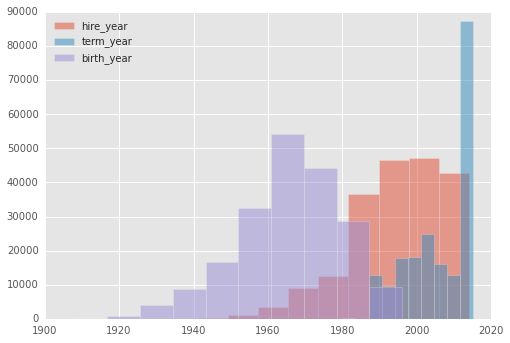

In [17]:
#get_numeric(empl_dates)
#hist_of_numeric(empl_dates)
     
for c in get_numeric(empl_dates):     
    empl_dates[c].hist(label=c,alpha=0.5)
    plt.legend(loc=2)
    


## READ the data June 10, 2015
* use employee_dataframe8.tsv --> contains text fields including dates for HIRE_DT..
* use employee_df_[1,2].csv --> contains just numeric data.
    - employee_df_1 has 180 columns:
        + Historical data there 
        + max value of EXT_FUNC_ID_SFI and FUNC_ID_SFI (represents missing ) changed to 2000.
        + median values used to fill missing values for float columns
        + COMPANY dropped
        + 'LOC_TYPE_DESCR_SFI','GRADE','LOC_STATE','JOB_FAMILY' label encoded
        + ANNUAL_RT droped in lieu of SAL1
        + BOX* kept; RATE*  dropped
        + PTFTCNT* kept; PARTFULL dropped
        + FTCNT* kept; FULLPART dropped
    - keep only the most recent historical data

In [18]:
empl_df = pd.read_csv('employee_df_1.csv')
empl_df.drop('Unnamed: 0', axis=1,inplace=True)
print empl_df.shape
empl_df.head()

(199419, 180)


,ADDRCNT1,ADDRCNT10,ADDRCNT3,ADDRCNT5,Age_years,BOX1,BOX10,BOX2,BOX3,BOX4,...,JOB_FUNCTION_PTH,JOB_FUNCTION_PTI,JOB_FUNCTION_PTJ,JOB_FUNCTION_PTK,JOB_FUNCTION_PTL,JOB_FUNCTION_PTM,loc_descr,state_code,grade_code,job_fcode
0,0,0,0,0,56.729433,2,2,2,2,3,...,0,0,0,0,0,0,18,1,113,606
1,1,1,1,1,21.322820,0,0,0,0,0,...,0,0,0,0,0,0,18,3,97,1108
2,0,0,0,0,38.566158,0,2,1,2,2,...,0,0,0,0,0,0,21,35,152,885
3,0,0,0,0,62.963647,2,2,2,2,2,...,0,0,0,0,0,0,18,9,99,834
4,0,1,1,1,26.853392,2,0,0,0,0,...,0,0,0,0,0,0,18,10,99,578


In [19]:
empl_df.job_fcode.head()

0     606
1    1108
2     885
3     834
4     578
Name: job_fcode, dtype: int64

## Import the unemployment measure into a DataFrame

In [20]:
### load in the federal unemployment data
unempl_raw = pd.read_csv('us_unemployment_monthly_seas.csv')
unempl_raw.head()
### convert to useable format
unempl = pd.melt(unempl_raw, id_vars='Year')
unempl.sort('Year', inplace=True)
unempl['date'] = unempl[['Year','variable']].apply(lambda x: pd.to_datetime(x[1]+str(x[0]),format='%b%Y'),axis=1)
unempl.sort('date',inplace=True)
unempl.head()

,Year,variable,value,date
0,1987,Jan,6.6,1987-01-01
29,1987,Feb,6.6,1987-02-01
58,1987,Mar,6.6,1987-03-01
87,1987,Apr,6.3,1987-04-01
116,1987,May,6.3,1987-05-01


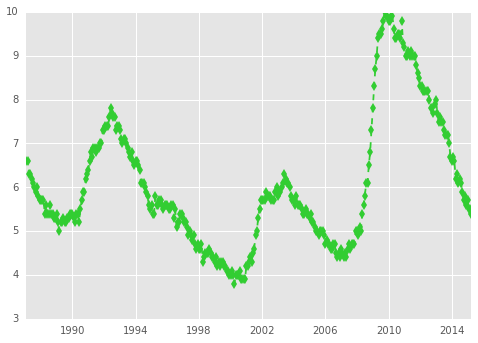

In [21]:
plt.plot(unempl.date,unempl.value,'d--',color='limegreen')

In [22]:
def assign_unempl_rate(my_date,unempl):
    try :
        un_rate = unempl[unempl.date <= my_date]['value'].values[-1]
    except IndexError:
        un_rate = unempl['value'].ix[0]
        
    return un_rate

In [23]:
## assign unemployement_rate
empl_df['unempl_rate'] = emplfull.TERMINATION_DT.apply(lambda x: assign_unempl_rate(x,unempl))

In [24]:
## create a column for terminated (i.e. separated but NOT retired)
empl_df['terminated']= 0
my_rows = empl_df[(empl_df.status==1) & (empl_df.retired==0)].index
print "Out of {0} rows, {1} are separated and not retired.".format(len(empl_df),len(my_rows))
#sum(empl_df['terminated']))#, len(my_rows)
empl_df.loc[my_rows,'terminated']=1
print sum(empl_df.terminated)

Out of 199419 rows, 106606 are separated and not retired.
106606


## Add a column for Age at Hire Date

In [25]:
## now calculate age at hire
hire_age_tdelta = empl_dates['hire_tstmp']-empl_dates['birth_tstmp']#)/np.timedelta64(1,'D')
# convert to days, months or years
empl_dates['hire_age'] = hire_age_tdelta/np.timedelta64(1,'Y')

#empl_dates.drop('hire_age_tdelta',axis=1,inplace=True)
empl_dates.head()

,hire_tstmp,term_tstmp,birth_tstmp,hire_year,term_year,birth_year,hire_age
0,1967-09-25,2004-08-31,1947-12-09,1967,2004,1947,19.795068
1,2014-06-09,2015-01-01,1993-09-05,2014,2015,1993,20.758811
2,1977-10-31,1997-06-16,1958-11-22,1977,1997,1958,18.940841
3,1975-09-11,2005-02-28,1942-03-14,1975,2005,1942,33.495554
4,2012-12-10,2015-01-01,1988-02-24,2012,2015,1988,24.794486


In [26]:
### push to emSets[1]
empl_df['hire_age']=empl_dates['hire_age']
#emSets[1][['Age_years','Tenure_years','hire_age']].head()

## Examine collinearity of these columns

In [27]:
collinearity_empl_df = perfect_collinearity_test(empl_df)

ADDRCNT1           VIF = 3.1   R^2 = 0.6798    
ADDRCNT10          VIF = 6.6   R^2 = 0.8476    
ADDRCNT3           VIF = 13.0  R^2 = 0.9228    
ADDRCNT5           VIF = 14.4  R^2 = 0.9304    

Age_years: PERFECT COLLINEARITY ********
['Tenure_years', 'hire_age']

BOX1               VIF = 5.2   R^2 = 0.8084    
BOX10              VIF = 11.1  R^2 = 0.9101    
BOX2               VIF = 6.8   R^2 = 0.854     
BOX3               VIF = 11.0  R^2 = 0.9089    
BOX4               VIF = 10.2  R^2 = 0.9024    
BOX5               VIF = 14.2  R^2 = 0.9298    
BOX6               VIF = 12.9  R^2 = 0.9222    
BOX7               VIF = 11.4  R^2 = 0.9127    
BOX8               VIF = 18.1  R^2 = 0.9446    
BOX9               VIF = 13.4  R^2 = 0.9251    
COMP_FREQUENCY     VIF = 5.2   R^2 = 0.8067    
CUR_DEPT_MOS       VIF = 5.0   R^2 = 0.7991    
CUR_EFUNC_MOS      VIF = 8.8   R^2 = 0.8869    
CUR_FUNC_MOS       VIF = 10.2  R^2 = 0.9022    
CUR_GRADE_MOS      VIF = 11.4  R^2 = 0.9121    
CUR_JOB_MOS     

In [28]:
collinearity_empl_df.sort(ascending=False)
collinearity_empl_df[collinearity_empl_df>0.95]

hire_age              1.000000
Age_years             1.000000
Tenure_years          1.000000
terminated            0.999979
status                0.999977
retired               0.999949
FLSA_STATUS           0.992444
EMPL_TYPE_S           0.990180
RELO_STATE_CNT_SFI    0.983669
SAL6                  0.983375
RELOCATE_ALL_SFI      0.983117
SAL5                  0.981533
SAL9                  0.981439
SAL3                  0.980338
SAL4                  0.979927
SAL7                  0.977276
SAL10                 0.976084
EMPL_CLASS_D          0.975647
SAL8                  0.975050
EEO1CODE_N            0.973793
SAL2                  0.973429
MIN_RT_ANNUAL         0.971595
LOCCNT5               0.970237
FTPTCNT3              0.970101
EMPL_TYPE_N           0.969878
DEPTCNT5              0.969811
FTPTCNT5              0.968868
JOBCNT5               0.968084
FTE                   0.967995
JOBCNT10              0.966120
PTFTCNT5              0.965051
SUPVCNT5              0.964186
FUNCCNT5

### Let's begin with just a few columns and revisit this later to get the logic correct
* further cleans-up the dataset
    1. clean-up (remove) historical data
    2. MOS data?
    3. Try to encode survival value for some categorical variables
        - JOB_FAMILY 
        - GRADE <-> grade_code
        - JOB_FAMILY <-> job_fcode (not used/recognized by HR)
        - JOBCODE <-> recast this into a form that has ordinal sense
    4. Revist columns to keep/exclude:
        - JOB FUNCTION IS categorical; 19 unique values
        - job_fcode should be but is label encoded as integers; 1456 unique values
        - EXTFUNC_CNT has 10352 unique values -->
        - EXT_FUNC_ID_SFI has 422 unique values
        - FUNC_CNT has 12070 unique values
        - FUNC_ID_SFI has 64 unique values
* build model based upon those with known separation ONLY
  - create a hold out (eval) set.
  - apply to current employees
  - question: _How to make this time-dependent?_
      * bucket the test set into time-segments

In [29]:
col_list = empl_df.columns.tolist()
print "empl_df has {0} columns.".format(len(col_list))

empl_df has 183 columns.


In [30]:
col_list = empl_df.columns.tolist()
three_cols = [x for x in col_list if x.endswith('CNT3')]
five_cols = [x for x in col_list if x.endswith('CNT5')]
ten_cols = [x for x in col_list if x.endswith('CNT10')]
# drop all BOX, MERIT, SAL, PERF and add back in those from last year
to_drop_cols = [x for x in col_list if x.startswith('PERF')]
to_drop_cols+= [x for x in col_list if x.startswith('SAL')]
to_drop_cols += [x for x in col_list if x.startswith('MERIT')]
to_drop_cols += [x for x in col_list if x.startswith('BOX')]
to_drop_cols+=three_cols
to_drop_cols+=five_cols
to_drop_cols+=ten_cols
to_add_cols = ['BOX1','SAL1','MERIT1','PERF1']
empl = empl_df.copy()
empl.drop(to_drop_cols,inplace=True,axis=1)
empl[to_add_cols] = empl_df[to_add_cols].copy()
print empl.shape ## this is the same as if I read in employee_df_2.csv

(199419, 111)


In [31]:
## check collinearity of this
empl_collin_test = perfect_collinearity_test(empl)

ADDRCNT1           VIF = 3.1   R^2 = 0.6739    

Age_years: PERFECT COLLINEARITY ********
['Tenure_years', 'hire_age']

COMP_FREQUENCY     VIF = 6.4   R^2 = 0.8435    
CUR_DEPT_MOS       VIF = 3.1   R^2 = 0.6723    
CUR_EFUNC_MOS      VIF = 5.3   R^2 = 0.8121    
CUR_FUNC_MOS       VIF = 7.1   R^2 = 0.8596    
CUR_GRADE_MOS      VIF = 6.8   R^2 = 0.8519    
CUR_JOB_MOS        VIF = 6.5   R^2 = 0.8469    
CUR_LOC_MOS        VIF = 4.3   R^2 = 0.7669    
DEPTCNT1           VIF = 6.1   R^2 = 0.8349    
DIRECT_RPT_CNT     VIF = 4.2   R^2 = 0.7615    
DIVISION_CODE_SFI  VIF = 5.5   R^2 = 0.8196    
EFUNCCNT1          VIF = 4.8   R^2 = 0.7927    
ETHNIC_GROUP       VIF = 1.8   R^2 = 0.4544    
EXTFUNC_CNT        VIF = 3.3   R^2 = 0.6935    
EXT_FUNC_ID_SFI    VIF = 4.9   R^2 = 0.7953    
FLOORCNT1          VIF = 2.2   R^2 = 0.5376    
FLOR_SFI           VIF = 4.5   R^2 = 0.7795    
FLSA_STATUS        VIF = 127.4 R^2 = 0.9921    
FTE                VIF = 43.8  R^2 = 0.9772    
FTPTCNT1        

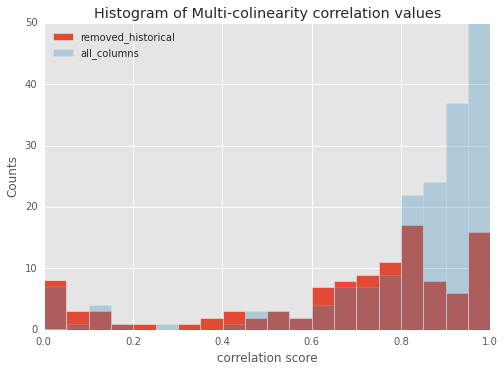

In [32]:
empl_collin_test.hist(label='removed_historical',bins=20)
collinearity_empl_df.hist(alpha=0.3,label='all_columns',bins=20)
plt.legend(loc=2)
plt.xlabel('correlation score')
plt.ylabel('Counts')
plt.title('Histogram of Multi-colinearity correlation values')

In [33]:
empl_collin_test[empl_collin_test>0.9]

Age_years             1.000000
FLSA_STATUS           0.992149
FTE                   0.977162
MAX_RT_ANNUAL         0.959480
MIN_RT_ANNUAL         0.957191
RELOCATE_ALL_SFI      0.956525
RELO_STATE_CNT_SFI    0.959231
status                0.999963
Tenure_years          1.000000
retired               0.999917
EMPL_TYPE_N           0.961310
EMPL_TYPE_S           0.990298
EEO1CODE_1            0.929071
EEO1CODE_2            0.925352
EEO1CODE_N            0.977727
EMPL_CLASS_D          0.982078
EMPL_CLASS_O          0.938123
EMPL_CLASS_T          0.945231
JOB_FUNCTION_MGT      0.908049
terminated            0.999966
hire_age              1.000000
SAL1                  0.923151
dtype: float64

In [34]:
reduced_cols = empl.columns.tolist()

## Begin to look at slicing in Time

In [35]:
emSets = []
date_list =['1994-01-01','1998-01-01','2002-01-01','2006-01-01']
print len(empl_df)
for date0 in date_list:
    my_em = empl_df.ix[emplfull.TERMINATION_DT>=date0].copy()
    emSets.append(my_em)
    print date0, len(my_em)
    print '----\n', my_em.status.value_counts()

199419
1994-01-01 177098
----
1    107292
0     69806
dtype: int64
1998-01-01 159376
----
1    89570
0    69806
dtype: int64
2002-01-01 135133
----
0    69806
1    65327
dtype: int64
2006-01-01 109589
----
0    69806
1    39783
dtype: int64


<Container object of 4 artists>

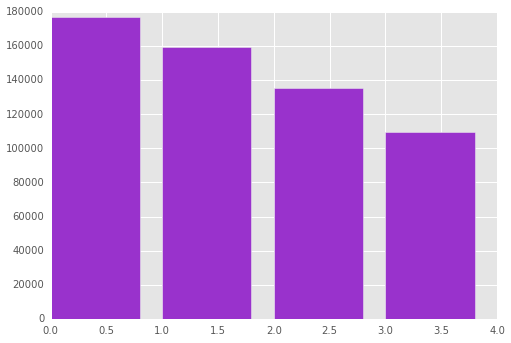

In [36]:
set_lengths = [len(em) for em in emSets]
plt.bar(np.arange(0,len(set_lengths)),set_lengths,color='darkorchid')


### Consider set B: index = 1
* length is 159376, split is 89570 to 69806
* date is 2002-01-01

In [37]:
collinearity_test_B = perfect_collinearity_test(emSets[1][reduced_cols])

ADDRCNT1           VIF = 3.1   R^2 = 0.6824    

Age_years: PERFECT COLLINEARITY ********
['Tenure_years', 'hire_age']

COMP_FREQUENCY     VIF = 8.0   R^2 = 0.8757    
CUR_DEPT_MOS       VIF = 3.0   R^2 = 0.6681    
CUR_EFUNC_MOS      VIF = 5.5   R^2 = 0.8193    
CUR_FUNC_MOS       VIF = 6.6   R^2 = 0.8488    
CUR_GRADE_MOS      VIF = 6.3   R^2 = 0.8419    
CUR_JOB_MOS        VIF = 6.0   R^2 = 0.8332    
CUR_LOC_MOS        VIF = 4.1   R^2 = 0.758     
DEPTCNT1           VIF = 6.3   R^2 = 0.8425    
DIRECT_RPT_CNT     VIF = 3.0   R^2 = 0.6721    
DIVISION_CODE_SFI  VIF = 6.2   R^2 = 0.8379    
EFUNCCNT1          VIF = 5.7   R^2 = 0.8246    
ETHNIC_GROUP       VIF = 1.7   R^2 = 0.418     
EXTFUNC_CNT        VIF = 3.4   R^2 = 0.7047    
EXT_FUNC_ID_SFI    VIF = 4.3   R^2 = 0.77      
FLOORCNT1          VIF = 1.9   R^2 = 0.4858    
FLOR_SFI           VIF = 5.3   R^2 = 0.8124    
FLSA_STATUS        VIF = 121.6 R^2 = 0.9918    
FTE                VIF = 24.0  R^2 = 0.9583    
FTPTCNT1        

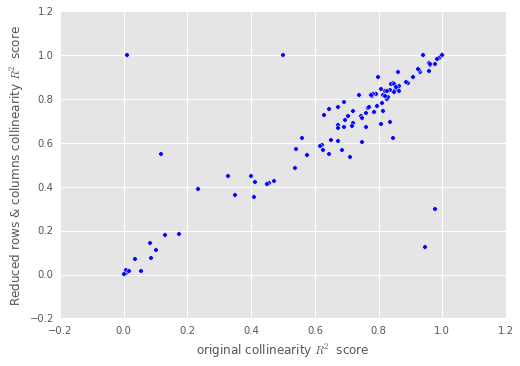

In [38]:
plt.scatter(empl_collin_test,collinearity_test_B)
plt.xlabel('original collinearity $R^2$ score')
plt.ylabel('Reduced rows & columns collinearity $R^2$ score')

In [39]:
collinearity_test_B[collinearity_test_B>0.9]

Age_years             1.000000
FLSA_STATUS           0.991774
FTE                   0.958310
MAX_RT_ANNUAL         0.957784
MIN_RT_ANNUAL         0.929878
RELOCATE_ALL_SFI      0.963912
RELO_STATE_CNT_SFI    0.964488
STD_HOURS             0.903074
status                0.999966
Tenure_years          1.000000
retired               0.999916
FULL_PART_TIME_P      0.925480
EMPL_TYPE_N           0.959998
EMPL_TYPE_S           0.990086
EEO1CODE_1            0.924046
EEO1CODE_2            0.934897
EEO1CODE_9            1.000000
EMPL_CLASS_D          0.983574
EMPL_CLASS_O          1.000000
EMPL_CLASS_P          1.000000
JOB_FUNCTION_MGT      0.900851
terminated            0.999966
hire_age              1.000000
SAL1                  0.935619
dtype: float64

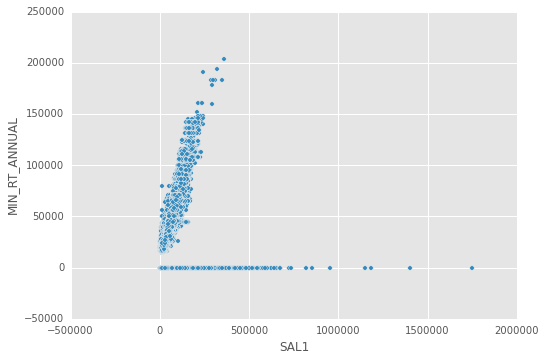

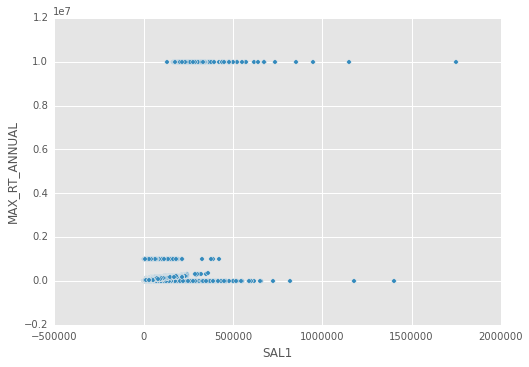

In [40]:
emSets[1].plot(kind='scatter',x='SAL1',y='MIN_RT_ANNUAL')
emSets[1].plot(kind='scatter',x='SAL1',y='MAX_RT_ANNUAL')

In [41]:
empl.terminated.value_counts()

1    106606
0     92813
dtype: int64

# June 15, 2015
1. need to eliminate all employees before a certain date in time: 
    * Begin with subset of employees that retired/terminated after 2002-02-01 (this is emSets[2])
2. Need to eliminate certain employees (rows) based upon job/grade type. 
    * typically because they are small groups/singletons and/or not going to be asked to model/predict upon. 
    * This includes:
        * pilots (Airtransport)
        * L-level
        * leadership development
        * agencytrainees?
        * UNS ~ Seasonal & temporary (already done)
3. I want to clean up some of the features
    * zeroed values for certain floats
    * how to collapse features for categorical data
    * remove columns for categories that become irrelevant because all instances are now zero (after truncation per #1 & #2)

##1. Create a subset (after 2002) of the employee records and the dates; use reduced columns

In [42]:
# create a copy of this subset (after 2002) and of dates
print emSets[2].shape
myEmpl = emSets[2][reduced_cols].copy()
myEmplDates = empl_dates.ix[myEmpl.index].copy()
print myEmpl.shape

(135133, 183)
(135133, 111)


## 2. look for uninformative columns and remove

In [43]:
after2002_collin_test = perfect_collinearity_test(myEmpl)

ADDRCNT1           VIF = 1.9   R^2 = 0.4838    

Age_years: PERFECT COLLINEARITY ********
['Tenure_years', 'hire_age']

COMP_FREQUENCY     VIF = 13.6  R^2 = 0.9267    
CUR_DEPT_MOS       VIF = 3.0   R^2 = 0.6655    
CUR_EFUNC_MOS      VIF = 5.1   R^2 = 0.8029    
CUR_FUNC_MOS       VIF = 6.3   R^2 = 0.8412    
CUR_GRADE_MOS      VIF = 5.9   R^2 = 0.8305    
CUR_JOB_MOS        VIF = 5.4   R^2 = 0.8147    
CUR_LOC_MOS        VIF = 3.9   R^2 = 0.7456    
DEPTCNT1           VIF = 5.6   R^2 = 0.8227    
DIRECT_RPT_CNT     VIF = 2.3   R^2 = 0.5662    
DIVISION_CODE_SFI  VIF = 6.0   R^2 = 0.8324    
EFUNCCNT1          VIF = 6.2   R^2 = 0.838     
ETHNIC_GROUP       VIF = 1.7   R^2 = 0.4187    
EXTFUNC_CNT        VIF = 4.1   R^2 = 0.7584    
EXT_FUNC_ID_SFI    VIF = 4.9   R^2 = 0.7942    
FLOORCNT1          VIF = 1.9   R^2 = 0.4843    
FLOR_SFI           VIF = 7.4   R^2 = 0.864     
FLSA_STATUS        VIF = 231.9 R^2 = 0.9957    
FTE                VIF = 3.3   R^2 = 0.6975    
FTPTCNT1        

In [44]:
after2002_collin_test[after2002_collin_test>0.95]

Age_years             1.000000
FLSA_STATUS           0.995688
MAX_RT_ANNUAL         0.988723
MIN_RT_ANNUAL         0.985944
RELOCATE_ALL_SFI      0.976867
RELO_STATE_CNT_SFI    0.977703
status                0.999966
Tenure_years          1.000000
retired               0.999915
FULL_PART_TIME_X      0.960235
EMPL_TYPE_N           0.993604
EMPL_TYPE_S           0.994858
EEO1CODE_1            0.958489
EEO1CODE_2            0.974460
EEO1CODE_9            1.000000
EMPL_CLASS_2          1.000000
EMPL_CLASS_D          0.995892
EMPL_CLASS_F          1.000000
EMPL_CLASS_O          1.000000
EMPL_CLASS_P          1.000000
JOB_FUNCTION_MGT      0.950517
JOB_FUNCTION_PTA      0.951597
terminated            0.999964
hire_age              1.000000
dtype: float64

In [45]:
myEmpl.EEO1CODE_1.value_counts()

0    122996
1     12137
dtype: int64

In [46]:
single_valued_cols = ['EMPL_CLASS_P','EMPL_CLASS_O','EMPL_CLASS_2','EMPL_CLASS_F','EEO1CODE_9','']
mos_columns = [x for x in reduced_cols if x.endswith('MOS')]
other_cols_to_drop = ['status','sep_status','EXTFUNC_CNT','EXT_FUNC_ID_SFI','FUNC_CNT','FUNC_ID_SFI','retired','terminated']
modeling_cols = list(set(reduced_cols)-set(single_valued_cols)-set(other_cols_to_drop)-set(mos_columns))
print len(reduced_cols), len(modeling_cols)

111 91


In [47]:
after2002_mdl_cols = perfect_collinearity_test(myEmpl[modeling_cols])

EMPL_CLASS_4       VIF = 3.0   R^2 = 0.6659    
EMPL_CLASS_5       VIF = 1.0   R^2 = 0.0019    
EMPL_CLASS_3       VIF = 1.5   R^2 = 0.3324    
FLSA_STATUS        VIF = 191.4 R^2 = 0.9948    
JOB_FUNCTION_NSA   VIF = 9.8   R^2 = 0.8977    
EEO1CODE_6         VIF = 1.1   R^2 = 0.049     
EEO1CODE_7         VIF = 1.4   R^2 = 0.2777    
EEO1CODE_4         VIF = 2.9   R^2 = 0.6512    
RELOCATE_ALL_SFI   VIF = 35.4  R^2 = 0.9718    
EEO1CODE_3         VIF = 1.6   R^2 = 0.3702    
EEO1CODE_1         VIF = 59.6  R^2 = 0.9832    
STD_HOURS          VIF = 21.5  R^2 = 0.9536    
FLOORCNT1          VIF = 1.9   R^2 = 0.4645    
EEO1CODE_8         VIF = 1.0   R^2 = 0.0024    
EEO1CODE_N         VIF = 1.1   R^2 = 0.1252    
EEO1CODE_L         VIF = 1.3   R^2 = 0.2185    
FTPTCNT1           VIF = 3.4   R^2 = 0.7099    
EFUNCCNT1          VIF = 4.5   R^2 = 0.7787    
TOTAL_RPT_CNT      VIF = 2.6   R^2 = 0.6097    
EMPL_CLASS_T       VIF = 1.5   R^2 = 0.3466    
unempl_rate        VIF = 1.5   R^2 = 0.3

In [48]:
myEmpl[['Age_years','Tenure_years','hire_age']].corr()

,Age_years,Tenure_years,hire_age
Age_years,1.000000,0.723911,0.450846
Tenure_years,0.723911,1.000000,-0.289428
hire_age,0.450846,-0.289428,1.000000


## pull out an evaluation set
* use test_train_split
* set up for running through a pipeline?

In [49]:
from sklearn import cross_validation

In [50]:
# store the indices of these as a new column
myEmpl['old_index']=myEmpl.index
print "Starting with subest of {0} employees.".format(len(myEmpl))
eval_fraction = 0.15
emBuild, emEval = cross_validation.train_test_split(myEmpl,test_size=eval_fraction)
print "Evaluation set has {0} employees; training set has {1} employees.".format(len(emEval),len(emBuild))

Starting with subest of 135133 employees.
Evaluation set has 20270 employees; training set has 114863 employees.


In [51]:
# reset the indices of these two sets and the dates
emBuild_dates = empl_dates.ix[emBuild.index].copy()
emEval_dates = empl_dates.ix[emEval.index].copy()
#build_indices = emBuild.index
#eval_indices = emEval.index
emBuild.index = np.arange(0,len(emBuild))
emBuild_dates.index = np.arange(0,len(emBuild))
emEval.index = np.arange(0,len(emEval))
emEval_dates.index= np.arange(0,len(emEval))

In [52]:
emBuild['JOBCODE'].value_counts()[:40]

90      8087
6200    5017
36      4106
167     3797
214     2833
89      2719
1876    2702
67      2595
61      2421
1009    2369
984     2101
13      2052
11      1982
9999    1890
501     1720
57      1554
212     1519
213     1491
2162    1306
2134    1231
14      1212
2120     926
4105     703
166      688
2639     650
22       648
169      586
500      562
4107     550
3141     522
2641     518
2164     512
10       480
1974     479
2638     467
3848     451
5383     441
3144     424
5384     419
4573     404
dtype: int64

In [53]:
#65*12 - 0
mthl_tenure_range = np.linspace(0,65,781)

## create function to return KMF median survival date of a given group

In [54]:
def return_first_time_survival(sfdf,thresh=0.5):
    from collections import defaultdict
    
    # assign all value to the default
    default_value = sfdf[sfdf['all']<=thresh].index[0]
    median_survival_dict = defaultdict(lambda: default_value)
    for c in sfdf.columns[1:]:
        #print c
        try:
            my_sf_date = sfdf[sfdf[c]<=thresh].index[0]
        except IndexError: # because never reached that threshold value
            my_sf_date = sfdf.index[-1]
        median_survival_dict[int(c)]=my_sf_date
    return median_survival_dict

In [55]:
def calculate_survival_functions(df,time_col, event_col, col_name,num_cutoff = 40,timerange =mthl_tenure_range):
    
    """ Function to generically return a dataframe of survival function, grouped by some categorical column
    inputs:
        df --> database to derive survival functions from
        time_col --> the temporal column to use for SF modeling (Kaplan Meier fitter applied)
        event_col --> the truncated column to use for SF modeling
        col_name --> the column to group up and determine KMF sf for
        num_cutoff --> number of groups to consider
    outputs:
        survivalfunc_df --> a data frame that contains survival function.

    other options:
        *frac_cutoff --> the fraction of unique elements that will be kept as separate groups
        *min_size_cutoff --> min size to use for the cutoff.
        * these last two are not implemented
    """
    from lifelines import KaplanMeierFitter
    kmf=KaplanMeierFitter()
    # create example for all cases -- serves as background
    # create a time range
    
    kmf.fit(df[time_col],timeline=timerange,event_observed=df[event_col],label='all')
    survivalfunc_df = pd.DataFrame(kmf.survival_function_)
    # groupify the dataframe
    grp_value_counts = df[col_name].value_counts()
    #if frac_cutoff == None:
    #    #by default take 15 %
    #    frac_cutoff = .15 
    #top_n_groups = int(frac_cutoff *len(grp_value_counts))
    #if min_size_cutoff == None:
        # by default 
    # Take the top num_cutoff groups
    my_grps = grp_value_counts.ix[:num_cutoff].index.tolist() 
    # make a list of elements in each of these groups
    grp_dict = {}
    for grp in my_grps: 
        grp_dict[grp] = df[df[col_name] == grp].index.tolist()
    # loop through grps and create kmf survival function
    for i,jgrp in enumerate(my_grps):
        j_idx = grp_dict[jgrp]
        #print i, jgrp, len(j_idx)
        kmf.fit(df[time_col].ix[j_idx],timeline=mthl_tenure_range,event_observed=df[event_col].ix[j_idx],label=str(jgrp))
        survivalfunc_df = pd.concat([survivalfunc_df,kmf.survival_function_],axis=1)
    
    
    return survivalfunc_df

## Add features for median survival function
### Use Tenure_years and terminated as the time and event columns
### Apply for JOBCODE, job_fcode, grade_code
* calc. the survival functions
* create the dictionary
* apply the dictionary and create a new column
* remove the base column


In [56]:
job_related_cols = ['JOBCODE','grade_code','job_fcode']
new_job_sf_cols = ['surv_med_jobcode','surv_med_grade','surv_med_jobfamily']
list_sf_dict = []
for i,col in enumerate(job_related_cols):
    print col, len(emBuild[col].value_counts())
    # calc survival functions
    sf_df = calculate_survival_functions(emBuild,'Tenure_years', 'terminated', col)#,num_cutoff = 40,timerange =mthl_tenure_range)
    # create the dictionary
    list_sf_dict.append(return_first_time_survival(sf_df,thresh=0.5))
    # apply the dictionary and create a new column
    emBuild[new_job_sf_cols[i]]= emBuild[job_related_cols[i]].apply(lambda x: list_sf_dict[i][x])
    emEval[new_job_sf_cols[i]] = emEval[job_related_cols[i]].apply(lambda x: list_sf_dict[i][x])
    #emB['med_surv'] = emB['JOBCODE'].apply(lambda x: med_survival[x] )
    #emB_eval['med_surv'] = emB_eval['JOBCODE'].apply(lambda x: med_survival[x] )

/home/kesj/envs/cutting/lib/python2.7/site-packages/IPython/kernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/kesj/envs/cutting/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


JOBCODE 2693
grade_code 142
job_fcode 1420


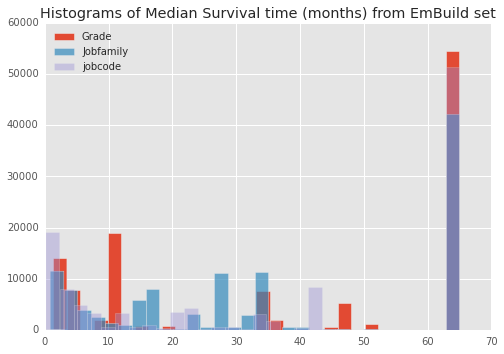

In [57]:
## examine the values of these new columns
emBuild.surv_med_grade.hist(label='Grade',bins=30)
emBuild.surv_med_jobfamily.hist(alpha=0.7,label='Jobfamily',bins=30)
emBuild.surv_med_jobcode.hist(alpha=0.4,label='jobcode',bins=30)
plt.legend(loc=2)
plt.title('Histograms of Median Survival time (months) from EmBuild set')
#emBuild.plot(kind='scatter',x =)


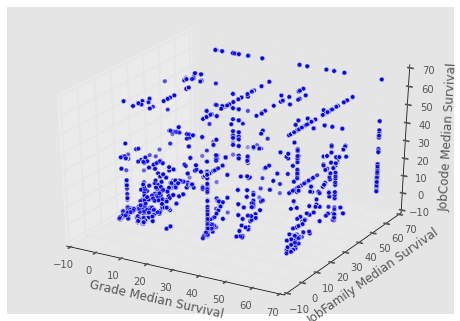

In [58]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(emBuild.surv_med_grade,emBuild.surv_med_jobfamily,emBuild.surv_med_jobcode)
#emBuild.plot(kind='scatter',x='surv_med_grade',y='surv_med_jobcode')
ax.set_xlabel('Grade Median Survival')
ax.set_ylabel('JobFamily Median Survival')
ax.set_zlabel('JobCode Median Survival')
plt.show()

In [59]:
emBuild[new_job_sf_cols].corr()

,surv_med_jobcode,surv_med_grade,surv_med_jobfamily
surv_med_jobcode,1.000000,0.769273,0.735575
surv_med_grade,0.769273,1.000000,0.551050
surv_med_jobfamily,0.735575,0.551050,1.000000


### looks like these values are not directly correlated try to add them all


In [60]:
print "Previous notion of modeling columns had {0} features.".format(len(modeling_cols))
# remove the job_related columns
# addd the last 3 columns about survival info
modeling_cols_2 = list(set(modeling_cols) - set(job_related_cols))
modeling_cols_2+=new_job_sf_cols
print "Current modeling columns has {0} features.".format(len(modeling_cols_2))

Previous notion of modeling columns had 91 features.
Current modeling columns has 91 features.


In [61]:
build_collin_tbl = perfect_collinearity_test(emBuild[modeling_cols_2])

EMPL_CLASS_4       VIF = 2.2   R^2 = 0.5385    
EMPL_CLASS_5       VIF = 1.0   R^2 = 0.002     
EMPL_CLASS_3       VIF = 1.2   R^2 = 0.156     
FLSA_STATUS        VIF = 184.8 R^2 = 0.9946    
JOB_FUNCTION_NSA   VIF = 9.0   R^2 = 0.8892    
EEO1CODE_6         VIF = 2.6   R^2 = 0.6079    
EEO1CODE_7         VIF = 1.9   R^2 = 0.4748    
EEO1CODE_4         VIF = 2.4   R^2 = 0.584     
RELOCATE_ALL_SFI   VIF = 73.1  R^2 = 0.9863    
EEO1CODE_3         VIF = 3.3   R^2 = 0.6971    
EEO1CODE_1         VIF = 29.9  R^2 = 0.9665    
STD_HOURS          VIF = 30497.9R^2 = 1.0       
FLOORCNT1          VIF = 2.1   R^2 = 0.5279    

EEO1CODE_8: PERFECT COLLINEARITY ********
[]

EEO1CODE_N         VIF = 1.6   R^2 = 0.3842    
EEO1CODE_L         VIF = 71.6  R^2 = 0.986     
FTPTCNT1           VIF = 1.6   R^2 = 0.3691    
EFUNCCNT1          VIF = 3.1   R^2 = 0.6736    
TOTAL_RPT_CNT      VIF = 3.4   R^2 = 0.7019    
EMPL_CLASS_T       VIF = 1.6   R^2 = 0.3569    
unempl_rate        VIF = 1.8   R^2 = 0.4

In [62]:
build_collin_tbl[build_collin_tbl>0.95]

FLSA_STATUS           0.994589
RELOCATE_ALL_SFI      0.986314
EEO1CODE_1            0.966550
STD_HOURS             0.999967
EEO1CODE_8            1.000000
EEO1CODE_L            0.986041
EMPL_CLASS_D          0.992929
Age_years             1.000000
JOB_FUNCTION_PSA      0.966453
RELO_STATE_CNT_SFI    0.986537
COMP_FREQUENCY        0.987880
hire_age              1.000000
FTE                   0.999968
JOB_FUNCTION_PTB      0.960183
MAX_RT_ANNUAL         0.993857
EEO1CODE_2            0.978627
JOB_FUNCTION_MGT      0.965929
SAL1                  0.963149
FULL_PART_TIME_X      0.978780
FULL_PART_TIME_P      0.986607
Tenure_years          1.000000
MIN_RT_ANNUAL         0.991999
EMPL_TYPE_N           0.966349
EMPL_TYPE_S           0.993836
dtype: float64

## construct a CV model for termination based upon this data (serves as baseline)

In [63]:
from sklearn import ensemble
from sklearn import metrics

In [64]:
# create the associated matrices
X = emBuild[modeling_cols_2].as_matrix().astype(np.float)
print np.shape(X)
y_tenure = emBuild.Tenure_years.as_matrix().astype(np.float)
y_term = emBuild.terminated.as_matrix().astype(np.int)

(114863, 91)


In [65]:
%%time 
baseline_singleRFC = ensemble.RandomForestClassifier(n_jobs=50,n_estimators=500,max_features=None)
baseline_singleRFC.fit(X,y_term)
baseline_singleRFC_importances= baseline_singleRFC.feature_importances_


CPU times: user 51min 15s, sys: 2.2 s, total: 51min 18s
Wall time: 1min 25s


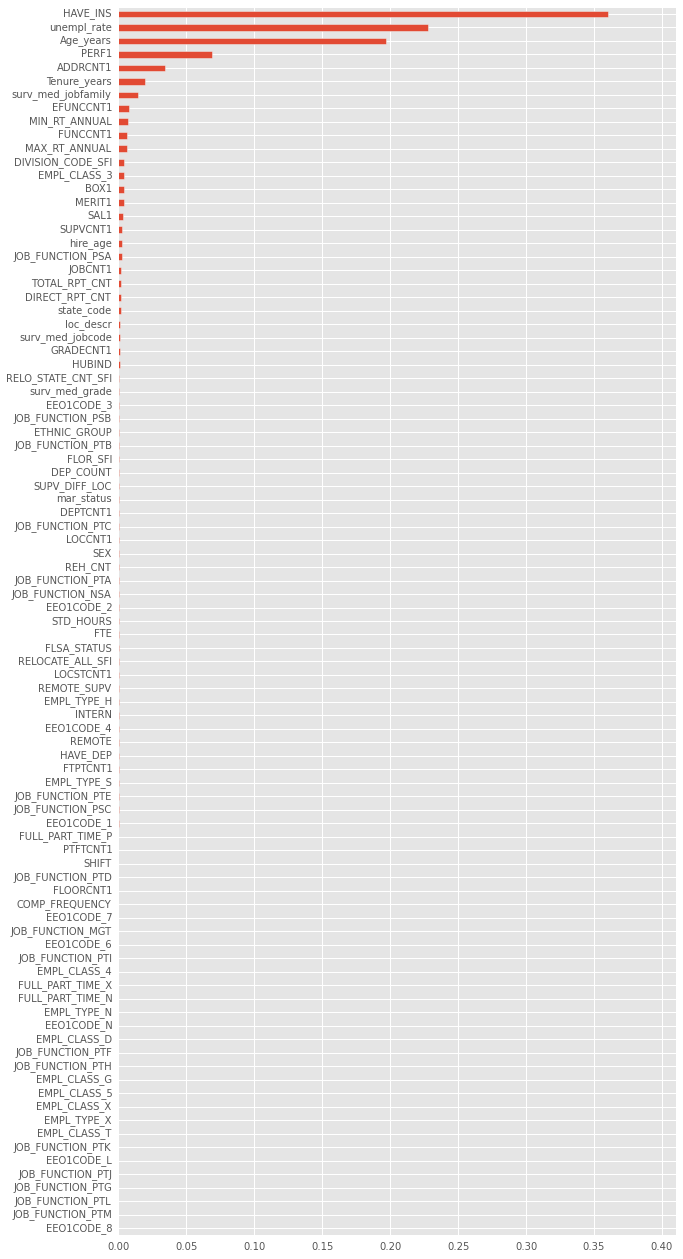

In [66]:
graph_feature_importances(baseline_singleRFC,modeling_cols_2)

In [67]:
# function to plot feature_importances for RF
def plotFI(forest,featureNames=[]):#,autoscale=True,headroom=0.05):
    """
    forest is the model to be graphed.
    featureNames is the list of features to be displayed
    
    """
    #if autoscale:
    #    x_scale = forest.feature_importances_.max()+ headroom
    #else:
    #    x_scale = 1
    
    featureImportances=forest.feature_importances_
    # sort the importances from biggest to least
    indices = np.argsort(featureImportances)[::-1]
    estimators = forest.estimators_
    # calculate the variance over the forest 
    
    std = np.std([tree.feature_importances_ for tree in estimators],axis=0)
    # print summary statement
    nfeatures = len(featureImportances)
    print("Number of Features: %d" % (nfeatures))
    print("Number of Trees: %d" %(len(estimators)))
    
    #print featureNames
    if len(featureNames)==0:
        featureNames = map(str,indices)
    
    fN2 = [featureNames[a] for a in indices]
    print("Feature ranking:")

    for f in range(len(indices)):
        print("%d. feature %d=%s (%f)" % (f + 1, indices[f], featureNames[indices[f]],featureImportances[indices[f]]))

    # Plot the feature importances of the forest
    # define a cutoff in terms of feature_importance
    if nfeatures <= 30:
        kfeatures = nfeatures # keep all if smaller than 30
    else:
        kfeatures = 30
        
    kindices = indices[:kfeatures]
    plt.title("Feature importances")
    plt.barh(range(len(kindices)), featureImportances[kindices],
       color="steelblue", xerr=std[kindices], align="center",ecolor='k')#,lw=2)
    #results.plot(kind="barh", figsize=(width,len(results)/4), xlim=(0,x_scale))
    plt.yticks(range(len(kindices)),fN2)
    #grid(True)
    c1 = 'value'
    c2 = 'std'
    tdata = np.vstack([featureImportances[indices],std[indices]])
    df = pd.DataFrame(data = tdata.T,index=fN2,columns=[c1,c2])
    return df
                      #indices, std
    #xticks(range(len(indices)), indices)
#xlim([-1, 10])

Number of Features: 91
Number of Trees: 500
Feature ranking:
1. feature 37=HAVE_INS (0.360698)
2. feature 20=unempl_rate (0.228181)
3. feature 28=Age_years (0.196672)
4. feature 27=PERF1 (0.068761)
5. feature 77=ADDRCNT1 (0.034361)
6. feature 76=Tenure_years (0.019360)
7. feature 90=surv_med_jobfamily (0.014695)
8. feature 17=EFUNCCNT1 (0.007772)
9. feature 80=MIN_RT_ANNUAL (0.007376)
10. feature 55=FUNCCNT1 (0.006466)
11. feature 52=MAX_RT_ANNUAL (0.006409)
12. feature 78=DIVISION_CODE_SFI (0.004373)
13. feature 2=EMPL_CLASS_3 (0.004041)
14. feature 54=BOX1 (0.003769)
15. feature 70=MERIT1 (0.003765)
16. feature 65=SAL1 (0.003247)
17. feature 56=SUPVCNT1 (0.002825)
18. feature 36=hire_age (0.002549)
19. feature 30=JOB_FUNCTION_PSA (0.002494)
20. feature 62=JOBCNT1 (0.001871)
21. feature 18=TOTAL_RPT_CNT (0.001810)
22. feature 79=DIRECT_RPT_CNT (0.001810)
23. feature 84=state_code (0.001660)
24. feature 66=loc_descr (0.001455)
25. feature 88=surv_med_jobcode (0.001374)
26. feature 64=G

,value,std
HAVE_INS,3.606984e-01,0.002938
unempl_rate,2.281810e-01,0.005653
Age_years,1.966717e-01,0.001963
PERF1,6.876065e-02,0.001654
ADDRCNT1,3.436147e-02,0.001183
Tenure_years,1.935952e-02,0.000973
surv_med_jobfamily,1.469465e-02,0.004316
EFUNCCNT1,7.772320e-03,0.004104
MIN_RT_ANNUAL,7.376221e-03,0.003404
FUNCCNT1,6.466332e-03,0.001976


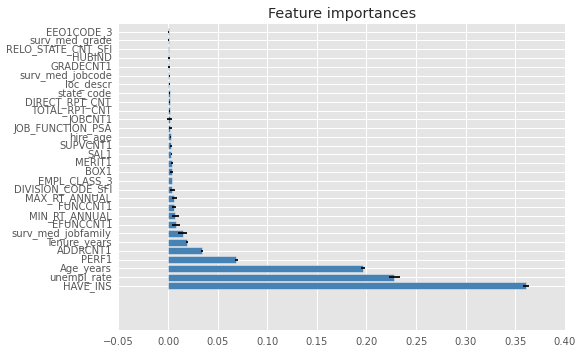

In [68]:
plotFI(baseline_singleRFC,modeling_cols_2)

In [69]:
# create a K-fold CV set of models (assumes roughly balanced
def kfold_cv(X, y, clf_class, shuffle=True, n_folds=10, **kwargs):
    k_fold = cross_validation.KFold(len(y), n_folds=n_folds, shuffle=shuffle)
    #y_pred = y.copy()
    kf_fits = []
    for ii, jj in k_fold:
        X_train, X_test = X[ii], X[jj]
        y_train = y[ii]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        kf_fits.append(clf)
        #y_pred[jj] = clf.predict(X_test)
    return k_fold,kf_fits

In [70]:
def plot_conf_matrix(y_true,y_pred,normed=True,**kwargs):
    my_c = metrics.confusion_matrix(y_true,y_pred)
    
    print metrics.matthews_corrcoef(y_true,y_pred)
    if normed:
        cm_normalized = my_c.astype('float') / my_c.sum(axis=1)[:, np.newaxis]
        my_c = cm_normalized
        plt.title('Normalized RF Classifier Confusion Matrix')
    else:
        plt.title('Random Forest Classifier Confusion Matrix')
        
    sns.heatmap(my_c, annot=True,  fmt='',cmap='Blues')
    plt.ylabel('True')
    #plt.yticks
    plt.xlabel('Assigned')
    plt.show()
    
    return

In [71]:
# create the associated matrices
Xeval = emEval[modeling_cols_2].as_matrix().astype(np.float)
print np.shape(Xeval)
#y_tenure = emBuild.Tenure_years.as_matrix().astype(np.float)
yeval_term = emEval.terminated.as_matrix().astype(np.int)

(20270, 91)


In [72]:
### Apply this model to the eval group
yeval_term_pred = baseline_singleRFC.predict(Xeval)

0.978987129518


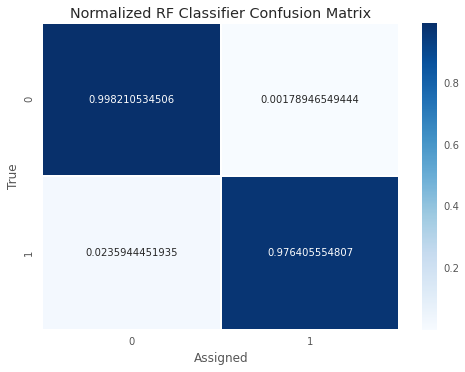

In [73]:
plot_conf_matrix(yeval_term,yeval_term_pred)

In [74]:
%%time 
CVscores = []
rfc_500trees, rfc_500fits = kfold_cv(X,y_term, ensemble.RandomForestClassifier,n_estimators =500, n_jobs=50)
for idx,(ii, jj) in enumerate(rfc_500trees):
    #print len(ii), len(jj)#, idx
    cv_train, cv_test = X[ii],X[jj]
    cv_score = rfc_500fits[idx].score(cv_test,y_term[jj])
    print idx,"\t",cv_score
    CVscores.append(cv_score)
print "Average CV score is {0}".format(np.mean(CVscores))

0 	0.987028815182
1 	0.989727518064
2 	0.988421694089
3 	0.98615706077
4 	0.988072436009
5 	0.987550060944
6 	0.985895873237
7 	0.986592373324
8 	0.988507748563
9 	0.988768936096
Average CV score is 0.987672251628
CPU times: user 52min 19s, sys: 22.9 s, total: 52min 42s
Wall time: 2min 43s


# Build the temporal kfold sets


### Requirements
* initial date
* final date
* time_delta
* employee DataFrame

In [75]:
full_date_range = [str(a)+'-01-01' for a in np.arange(2002,2016)]
print len(full_date_range)

14


In [76]:
min_date = pd.to_datetime(full_date_range[0])
max_date = pd.to_datetime(full_date_range[-1])
print type(max_date - min_date),np.int(np.round((max_date-min_date).days/365.24,0))
for a in xrange(0,3):
    print a, full_date_range[a::3]

<class 'pandas.tslib.Timedelta'> 13
0 ['2002-01-01', '2005-01-01', '2008-01-01', '2011-01-01', '2014-01-01']
1 ['2003-01-01', '2006-01-01', '2009-01-01', '2012-01-01', '2015-01-01']
2 ['2004-01-01', '2007-01-01', '2010-01-01', '2013-01-01']


In [77]:
def create_temporal_kfolds(dates_df,date_range,time_delta):
    min_date = pd.to_datetime(date_range[0])
    max_date = pd.to_datetime(date_range[-1])
    my_index = dates_df[(dates_df.term_tstmp>=min_date)].index
    # calculate number of kfolds
    date_span_years = np.int(np.round((max_date-min_date).days/365.24,0))
    nfolds = date_span_years - time_delta
    print date_span_years, time_delta, nfolds, len(my_index)
    all_pairs = list(itertools.combinations(date_range,2))
    # now filter if difference in time  == time_delta
    filtered_pairs = []
    for i0,i1 in all_pairs:
        if int(i1[:4])-int(i0[:4]) == time_delta:
            filtered_pairs.append([i0,i1])
            #print i0,i1
    print len(filtered_pairs)
    # now process each of these filtered pairs
    kf = []
    for j0,j1 in filtered_pairs: # omit the last one because it has no
        start_date = pd.to_datetime(j0)
        end_date = pd.to_datetime(j1)
        #print j0,j1#,len(k)
        
        
        kfold_idx = dates_df[(dates_df.term_tstmp >= start_date) & (dates_df.hire_tstmp<start_date)].index
        after_idx = dates_df[(dates_df.hire_tstmp>=end_date)].index
        before_idx = list(set(my_index)-set(kfold_idx)-set(after_idx))
        #temporal_kfold(dates_df[dates_df.term_tstmp>=min_date],start_date,end_date)
        #print "\t",len(kfold_idx), len(after_idx),len(before_idx)
        
        # combined out of fold
        not_kfold_idx = list(set(after_idx).union(set(before_idx)))
        
        print j0,j1,len(kfold_idx),len(not_kfold_idx)
        kf.append([kfold_idx,not_kfold_idx])
    
    return kf,filtered_pairs
    

In [78]:
def reset_years(paired_times,indices,dates_df,df,cols_to_alter = ['Age_years','Tenure_years']):
    # calc the Age at beginnning of time period
    ## now calculate age at hire
    reset_age_tdelta = pd.to_datetime(paired_times[0])-dates_df['birth_tstmp']#)/np.timedelta64(1,'D')
    reset_tenure_tdelta = pd.to_datetime(paired_times[0])-dates_df['hire_tstmp']#)/np.timedelta64(1,'D')
    # convert to days, months or years
    reset_age = reset_age_tdelta/np.timedelta64(1,'Y')
    reset_tenure = reset_tenure_tdelta/np.timedelta64(1,'Y')
    # look at terminated or not
    #empl_df['terminated']= 0
    
    
#my_rows = empl_df[(empl_df.status==1) & (empl_df.retired==0)].index
#print "Out of {0} rows, {1} are separated and not retired.".format(len(empl_df),len(my_rows))
##sum(empl_df['terminated']))#, len(my_rows)
#empl_df.loc[my_rows,'terminated']=1
#print sum(empl_df.terminated)
#    if 
    return reset_age,reset_tenure
    

In [79]:
five_yr_tfolds,five_yr_times = create_temporal_kfolds(emBuild_dates,full_date_range,5)

13 5 8 114863
9
2002-01-01 2007-01-01 66984 47879
2003-01-01 2008-01-01 64900 49963
2004-01-01 2009-01-01 61365 53498
2005-01-01 2010-01-01 58168 56695
2006-01-01 2011-01-01 56711 58152
2007-01-01 2012-01-01 56478 58385
2008-01-01 2013-01-01 55972 58891
2009-01-01 2014-01-01 56595 58268
2010-01-01 2015-01-01 55914 58949


## take the temporal time fold splits and apply this logic
1. for each fold reset the included values to be relative to start date
2. for each fold reassign terminated values as within that time frame
    * actually make a new data-frame with new columns corresponding to termination-within_x-years type of calculation


In [80]:
emBuild.ix[five_yr_tfolds[0][0]].terminated.value_counts()

0    45191
1    21793
dtype: int64

In [81]:
sum(emBuild_dates.ix[five_yr_tfolds[0][0]]['term_tstmp'] <= five_yr_times[0][1])
#emBuild.ix[five_yr_tfolds[0][0]]

21454

In [82]:
new_term = (emBuild_dates.ix[five_yr_tfolds[0][0]]['term_tstmp']<= five_yr_times[0][1]).as_matrix().astype(np.int)

In [83]:
sum(emBuild_dates.ix[five_yr_tfolds[0][0]]['term_tstmp'] > five_yr_times[0][1])
#emBuild.ix[five_yr_tfolds[0][0]]

45530

In [84]:
def find_termination_within_x_years(dates_df,df,paired_dates,tfold,n_years):
    print len(tfold)#, paired_dates
    
    df_dict = {}
    for i,tf in enumerate(tfold):
        start_date = paired_dates[i][0]
        end_date = paired_dates[i][1]
        print start_date,end_date,n_years
        #altered_fold_df = pd.DataFrame(columns=['fold_mbr','adj_age','adj_tenure','adj_term'])
        # if in the fold reset the age to start of fold; define new window of termination
        in_fold_idx = tfold[i][0]
        altered_fold_df= df[['SEX','Age_years','Tenure_years','terminated']].copy()
        # adjust these
        altered_fold_df.columns=['fold_mbr','adj_age','adj_tenure','adj_term']
        altered_fold_df.fold_mbr = 0
        
        ra,rt = reset_years(paired_dates,in_fold_idx,dates_df,df)
        altered_fold_df.ix[in_fold_idx]['adj_age']=ra
        altered_fold_df.ix[in_fold_idx]['adj_tenure']=rt
        new_term = (dates_df.ix[in_fold_idx]['term_tstmp']<= end_date).as_matrix().astype(np.int)
        # deal with last time-fold specially
        if i == len(tfold)-1:
            new_term = (dates_df.ix[in_fold_idx]['term_tstmp']< end_date).as_matrix().astype(np.int)
        #print "\t", len(new_term),sum(new_term)
        altered_fold_df.loc[in_fold_idx,'adj_term']=new_term
        altered_fold_df.loc[in_fold_idx,'fold_mbr']=1
        df_dict[i]=altered_fold_df
    # now append this to a larger panel
    tfold_panel = pd.Panel.from_dict(data =df_dict)    
    return tfold_panel

In [85]:
fivePanel = find_termination_within_x_years(emBuild_dates,emBuild,five_yr_times,five_yr_tfolds,5)
#emBuild.ix[five_yr_tfolds[0][0]][emBuild_dates.ix[five_yr_tfolds[0][0]]['term_tstmp'] > five_yr_times[0][1]]#.as_matrix().astype(np.int)
#emBuild.ix[five_yr_tfolds[0][0]]

9
2002-01-01 2007-01-01 5
2003-01-01 2008-01-01 5
2004-01-01 2009-01-01 5
2005-01-01 2010-01-01 5
2006-01-01 2011-01-01 5
2007-01-01 2012-01-01 5
2008-01-01 2013-01-01 5
2009-01-01 2014-01-01 5
2010-01-01 2015-01-01 5


In [86]:
[(a,fivePanel[a].ix[five_yr_tfolds[a][0]].adj_term.sum(),sum(fivePanel[a].fold_mbr)) for a in xrange(0,9)]

[(0, 21454.0, 66984.0),
 (1, 20099.0, 64900.0),
 (2, 17329.0, 61365.0),
 (3, 13666.0, 58168.0),
 (4, 11335.0, 56711.0),
 (5, 10801.0, 56478.0),
 (6, 11060.0, 55972.0),
 (7, 12328.0, 56595.0),
 (8, 13309.0, 55914.0)]

## so now build a model from each of these sets
* extract the age & tenure relative to the beginning of the fold and the termination (y) from the proper panel
* get other variables from the bulk dataframe

In [87]:
X.shape

(114863, 91)

In [88]:
tfold_modeling_cols = list( set(modeling_cols_2) - set(['Age_years','Tenure_years']))
print len(tfold_modeling_cols)
# do this for each fold
X5fold = np.zeros((len(emBuild),len(tfold_modeling_cols)+2,len(five_yr_tfolds)))
print X5fold.shape
#y5fold = np.zeros((len(emBuild),len(five_yr_tfolds)))

89
(114863, 91, 9)


In [89]:
#[(a,emBuild.ix[five_yr_tfolds[a][0]].terminated.sum()) for a in xrange(0,9)]
## So now
y5fold = []
for i in xrange(0,len(five_yr_tfolds)):
    X5fold[:,:-2,i]=emBuild[tfold_modeling_cols].as_matrix().astype(np.float)
    X5fold[:,-2:,i]=fivePanel[i][['adj_age','adj_tenure']]
    my_y=fivePanel[i][['adj_term']].as_matrix().astype(np.int)
    y5fold.append(my_y)

In [90]:
%%time
tfold_rf_mdl = []
for i in xrange(0,len(five_yr_tfolds)):
    train_y = y5fold[i].flatten()[five_yr_tfolds[i][0]]
    train_X = X5fold[five_yr_tfolds[i][0],:,i]
    rfmdl = ensemble.RandomForestClassifier(n_jobs=50,n_estimators=500,max_features=None)
    rfmdl.fit(train_X,train_y)
#baseline_singleRFC = ensemble.RandomForestClassifier(n_jobs=50,n_estimators=500,max_features=None)
#baseline_singleRFC.fit(X,y_term)
#baseline_singleRFC_importances= baseline_singleRFC.feature_importances_
    tfold_rf_mdl.append(rfmdl)

CPU times: user 1h 56min 13s, sys: 12.3 s, total: 1h 56min 25s
Wall time: 4min 6s


Number of Features: 91
Number of Trees: 500
Feature ranking:
1. feature 20=unempl_rate (0.372444)
2. feature 90=adj_tenure (0.359729)
3. feature 74=surv_med_jobfamily (0.054505)
4. feature 66=loc_descr (0.053831)
5. feature 70=MERIT1 (0.013892)
6. feature 89=adj_age (0.012585)
7. feature 28=PERF1 (0.011711)
8. feature 81=MIN_RT_ANNUAL (0.010340)
9. feature 65=SAL1 (0.009350)
10. feature 85=state_code (0.008493)
11. feature 52=MAX_RT_ANNUAL (0.008237)
12. feature 36=hire_age (0.007483)
13. feature 18=TOTAL_RPT_CNT (0.007345)
14. feature 54=BOX1 (0.005812)
15. feature 80=DIRECT_RPT_CNT (0.005483)
16. feature 33=RELO_STATE_CNT_SFI (0.004599)
17. feature 31=JOB_FUNCTION_PSB (0.004061)
18. feature 79=DIVISION_CODE_SFI (0.003699)
19. feature 64=GRADECNT1 (0.003618)
20. feature 60=DEP_COUNT (0.003262)
21. feature 27=surv_med_jobcode (0.003133)
22. feature 77=surv_med_grade (0.002693)
23. feature 56=SUPVCNT1 (0.002644)
24. feature 30=JOB_FUNCTION_PSA (0.002577)
25. feature 26=FLOR_SFI (0.00220

,value,std
unempl_rate,3.724441e-01,0.005009
adj_tenure,3.597294e-01,0.004104
surv_med_jobfamily,5.450477e-02,0.002992
loc_descr,5.383075e-02,0.002264
MERIT1,1.389227e-02,0.002401
adj_age,1.258509e-02,0.001664
PERF1,1.171110e-02,0.001713
MIN_RT_ANNUAL,1.034010e-02,0.001734
SAL1,9.349522e-03,0.001574
state_code,8.493434e-03,0.001669


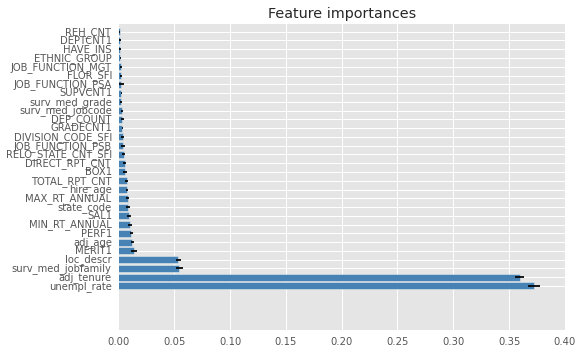

In [91]:
feature_names = tfold_modeling_cols
feature_names+=['adj_age','adj_tenure']
plotFI(tfold_rf_mdl[0],feature_names)

Number of Features: 91
Number of Trees: 500
Feature ranking:
1. feature 20=unempl_rate (0.623173)
2. feature 90=adj_tenure (0.189704)
3. feature 66=loc_descr (0.067835)
4. feature 52=MAX_RT_ANNUAL (0.010498)
5. feature 81=MIN_RT_ANNUAL (0.008552)
6. feature 70=MERIT1 (0.008370)
7. feature 28=PERF1 (0.007388)
8. feature 89=adj_age (0.006287)
9. feature 18=TOTAL_RPT_CNT (0.006231)
10. feature 54=BOX1 (0.005627)
11. feature 65=SAL1 (0.005551)
12. feature 60=DEP_COUNT (0.005183)
13. feature 74=surv_med_jobfamily (0.004869)
14. feature 80=DIRECT_RPT_CNT (0.004661)
15. feature 85=state_code (0.003923)
16. feature 36=hire_age (0.003817)
17. feature 31=JOB_FUNCTION_PSB (0.003541)
18. feature 64=GRADECNT1 (0.002887)
19. feature 33=RELO_STATE_CNT_SFI (0.002793)
20. feature 77=surv_med_grade (0.002055)
21. feature 27=surv_med_jobcode (0.002052)
22. feature 37=HAVE_INS (0.001975)
23. feature 26=FLOR_SFI (0.001675)
24. feature 63=JOB_FUNCTION_MGT (0.001658)
25. feature 79=DIVISION_CODE_SFI (0.00164

,value,std
unempl_rate,6.231731e-01,0.007279
adj_tenure,1.897044e-01,0.003420
loc_descr,6.783451e-02,0.004498
MAX_RT_ANNUAL,1.049804e-02,0.004285
MIN_RT_ANNUAL,8.551646e-03,0.002519
MERIT1,8.370296e-03,0.001555
PERF1,7.388073e-03,0.001669
adj_age,6.287488e-03,0.001500
TOTAL_RPT_CNT,6.231202e-03,0.003549
BOX1,5.627405e-03,0.001625


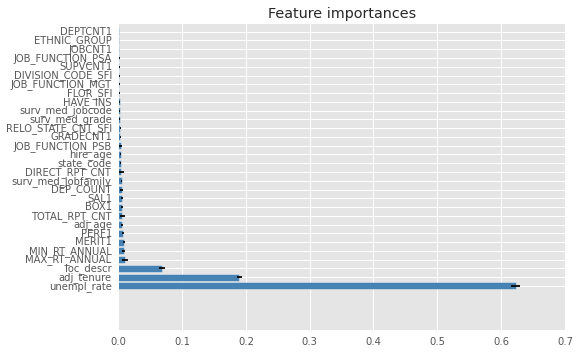

In [92]:
plotFI(tfold_rf_mdl[1],feature_names)

In [93]:
def plot_roc_curve(target_test, target_predicted_proba):
    fpr, tpr, thresholds = metrics.roc_curve(target_test, target_predicted_proba[:, 1])
    
    roc_auc = metrics.auc(fpr, tpr)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    return roc_auc

Number of Features: 91
Number of Trees: 500
Feature ranking:
1. feature 20=unempl_rate (0.867870)
2. feature 90=adj_tenure (0.058623)
3. feature 70=MERIT1 (0.017831)
4. feature 37=HAVE_INS (0.008428)
5. feature 89=adj_age (0.006121)
6. feature 81=MIN_RT_ANNUAL (0.004384)
7. feature 52=MAX_RT_ANNUAL (0.003684)
8. feature 28=PERF1 (0.002654)
9. feature 31=JOB_FUNCTION_PSB (0.002605)
10. feature 9=EEO1CODE_3 (0.002187)
11. feature 60=DEP_COUNT (0.002033)
12. feature 36=hire_age (0.001872)
13. feature 65=SAL1 (0.001819)
14. feature 18=TOTAL_RPT_CNT (0.001718)
15. feature 85=state_code (0.001465)
16. feature 80=DIRECT_RPT_CNT (0.001254)
17. feature 56=SUPVCNT1 (0.001226)
18. feature 33=RELO_STATE_CNT_SFI (0.000994)
19. feature 74=surv_med_jobfamily (0.000980)
20. feature 27=surv_med_jobcode (0.000847)
21. feature 54=BOX1 (0.000819)
22. feature 79=DIVISION_CODE_SFI (0.000745)
23. feature 77=surv_med_grade (0.000643)
24. feature 88=DEPTCNT1 (0.000586)
25. feature 66=loc_descr (0.000535)
26. f

,value,std
unempl_rate,8.678696e-01,0.003932
adj_tenure,5.862310e-02,0.002486
MERIT1,1.783052e-02,0.001555
HAVE_INS,8.427724e-03,0.001269
adj_age,6.121066e-03,0.001371
MIN_RT_ANNUAL,4.384135e-03,0.001423
MAX_RT_ANNUAL,3.684234e-03,0.001340
PERF1,2.654353e-03,0.000795
JOB_FUNCTION_PSB,2.605090e-03,0.000694
EEO1CODE_3,2.186772e-03,0.000638


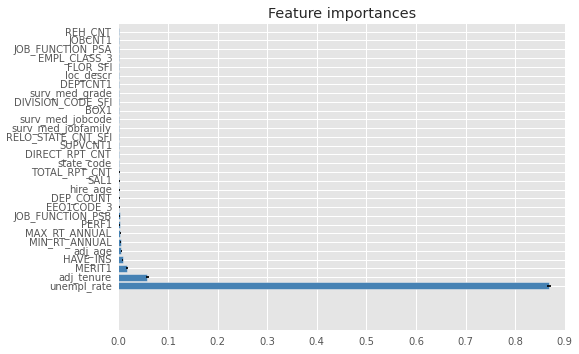

In [94]:
plotFI(tfold_rf_mdl[6],feature_names)

0.101021957888


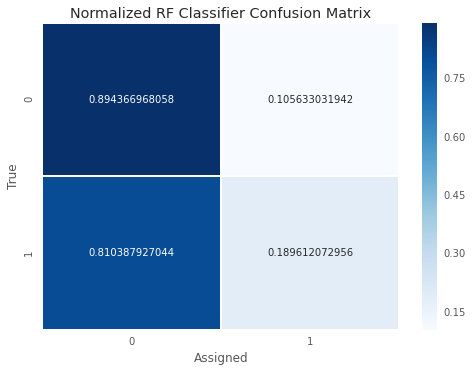

In [95]:
pred0to5 = tfold_rf_mdl[0].predict(X5fold[five_yr_tfolds[5][0],:,5])
plot_conf_matrix(y5fold[5].flatten()[five_yr_tfolds[5][0]],pred0to5)

In [96]:
proba_pred0to5 = tfold_rf_mdl[0].predict_proba(X5fold[five_yr_tfolds[5][0],:,5])
y_true5 = y5fold[5].flatten()[five_yr_tfolds[5][0]]

0.64507814789970142

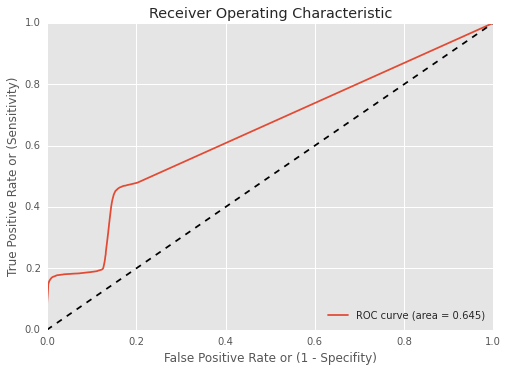

In [97]:
plot_roc_curve(y_true5,proba_pred0to5)

In [98]:
proba_pred0to6 = tfold_rf_mdl[0].predict_proba(X5fold[five_yr_tfolds[6][0],:,6])
y_true6 = y5fold[6].flatten()[five_yr_tfolds[6][0]]

0.4916504662765071

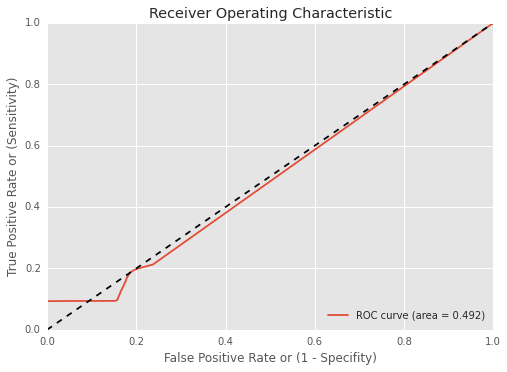

In [99]:
plot_roc_curve(y_true6,proba_pred0to6)

In [100]:
proba_pred0to7 = tfold_rf_mdl[0].predict_proba(X5fold[five_yr_tfolds[7][0],:,7])
y_true7 = y5fold[7].flatten()[five_yr_tfolds[7][0]]

0.36514455809400465

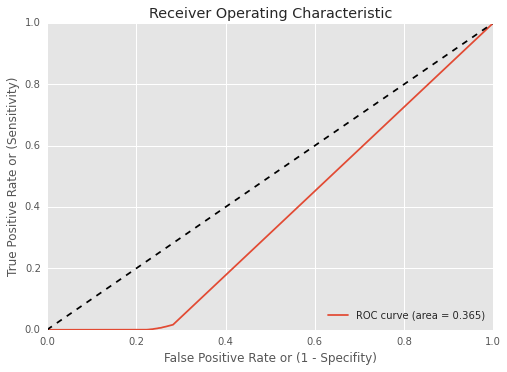

In [101]:
plot_roc_curve(y_true7,proba_pred0to7)

In [102]:
proba_pred0to5 = tfold_rf_mdl[0].predict_proba(X5fold[five_yr_tfolds[5][0],:,5])
y_true5 = y5fold[5].flatten()[five_yr_tfolds[5][0]]

In [103]:
five_yr_times

[['2002-01-01', '2007-01-01'],
 ['2003-01-01', '2008-01-01'],
 ['2004-01-01', '2009-01-01'],
 ['2005-01-01', '2010-01-01'],
 ['2006-01-01', '2011-01-01'],
 ['2007-01-01', '2012-01-01'],
 ['2008-01-01', '2013-01-01'],
 ['2009-01-01', '2014-01-01'],
 ['2010-01-01', '2015-01-01']]

### Try again without the unemployment data

In [104]:
tfold_modeling_colsB = list( set(tfold_modeling_cols[:-2]) - set(['unempl_rate']))

# do this for each fold
X5foldB = np.zeros((len(emBuild),len(tfold_modeling_colsB)+2,len(five_yr_tfolds)))
print X5fold.shape

(114863, 91, 9)


In [105]:
for i in xrange(0,len(five_yr_tfolds)):
    X5foldB[:,:-2,i]=emBuild[tfold_modeling_colsB].as_matrix().astype(np.float)
    X5foldB[:,-2:,i]=fivePanel[i][['adj_age','adj_tenure']]
    #my_y=fivePanel[i][['adj_term']].as_matrix().astype(np.int)
    #y5fold.append(my_y)

In [106]:
%%time
tfold_rf_mdlB = []
for i in xrange(0,len(five_yr_tfolds)):
    train_y = y5fold[i].flatten()[five_yr_tfolds[i][0]]
    train_X = X5foldB[five_yr_tfolds[i][0],:,i]
    rfmdl = ensemble.RandomForestClassifier(n_jobs=50,n_estimators=500,max_features=None)
    rfmdl.fit(train_X,train_y)
#baseline_singleRFC = ensemble.RandomForestClassifier(n_jobs=50,n_estimators=500,max_features=None)
#baseline_singleRFC.fit(X,y_term)
#baseline_singleRFC_importances= baseline_singleRFC.feature_importances_
    tfold_rf_mdlB.append(rfmdl)

CPU times: user 3h 1min 2s, sys: 11.8 s, total: 3h 1min 14s
Wall time: 5min 16s


In [107]:
len(feature_names)

91

Number of Features: 90
Number of Trees: 500
Feature ranking:
1. feature 89=adj_age (0.396601)
2. feature 65=SAL1 (0.131083)
3. feature 80=DIRECT_RPT_CNT (0.100977)
4. feature 51=JOB_FUNCTION_PTB (0.066478)
5. feature 73=REH_CNT (0.043867)
6. feature 32=JOB_FUNCTION_PSC (0.024484)
7. feature 69=FULL_PART_TIME_X (0.020659)
8. feature 64=GRADECNT1 (0.020629)
9. feature 29=HUBIND (0.017511)
10. feature 88=DEPTCNT1 (0.016745)
11. feature 18=TOTAL_RPT_CNT (0.014716)
12. feature 84=EMPL_TYPE_S (0.014473)
13. feature 27=surv_med_jobcode (0.014115)
14. feature 35=COMP_FREQUENCY (0.012715)
15. feature 79=DIVISION_CODE_SFI (0.011405)
16. feature 26=FLOR_SFI (0.006724)
17. feature 78=ADDRCNT1 (0.006037)
18. feature 59=ETHNIC_GROUP (0.005706)
19. feature 36=hire_age (0.005498)
20. feature 76=INTERN (0.005311)
21. feature 9=EEO1CODE_3 (0.004588)
22. feature 48=JOB_FUNCTION_PTF (0.004169)
23. feature 25=EMPL_CLASS_D (0.003107)
24. feature 53=LOCCNT1 (0.003049)
25. feature 62=JOBCNT1 (0.003039)
26. fe

,value,std
adj_age,3.966012e-01,0.003860
SAL1,1.310830e-01,0.003770
DIRECT_RPT_CNT,1.009770e-01,0.007356
JOB_FUNCTION_PTB,6.647782e-02,0.006791
REH_CNT,4.386668e-02,0.005219
JOB_FUNCTION_PSC,2.448387e-02,0.005541
FULL_PART_TIME_X,2.065946e-02,0.003155
GRADECNT1,2.062941e-02,0.002540
HUBIND,1.751052e-02,0.003482
DEPTCNT1,1.674542e-02,0.002472


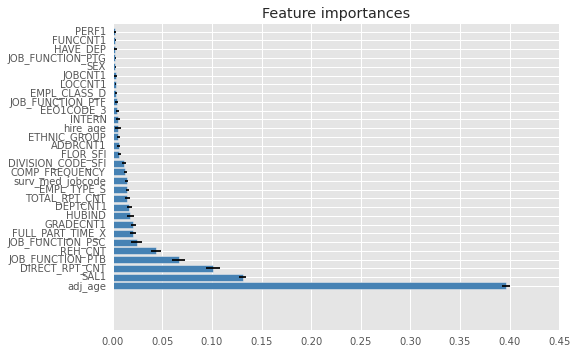

In [108]:
#fn2 = feature_names.remove('unempl_rate')
plotFI(tfold_rf_mdlB[0],feature_names)

In [109]:
def create_fi_df(mdl_list,feature_names):
    list_feature_importances = []
    col_list = []
    for i,mdl in enumerate(mdl_list):
        list_feature_importances.append(plotFI(mdl,feature_names))
        col_list.append('fold'+str(i)+'_value')
        col_list.append('fold'+str(i)+'_std')

    fi_df = pd.concat(list_feature_importances,axis=1)
    # create column headings
    fi_df.columns = col_list
    # create the average of the values
    value_cols = [x for x in col_list if x.endswith('value')]
    
    fi_df['avg_val']=fi_df[value_cols].mean(axis=1)
    fi_df['avg_variance']=fi_df[value_cols].std(axis=1)
#t2_eval_fi_df[['avg_val','avg_std']].sort('avg_val',ascending=False)
    return fi_df


In [110]:
Bproba_pred0to7 = tfold_rf_mdlB[0].predict_proba(X5foldB[five_yr_tfolds[7][0],:,7])
y_true7 = y5fold[7].flatten()[five_yr_tfolds[7][0]]

In [ ]:
plot_conf_matrix(y_true7,map(int,Bproba_pred0to7[:,1]+.4))

In [ ]:
plt.scatter(y_true7,Bproba_pred0to7[:,0])

In [ ]:
plot_roc_curve(y_true7,Bproba_pred0to7)

Number of Features: 90
Number of Trees: 500
Feature ranking:
1. feature 89=adj_age (0.396601)
2. feature 65=SAL1 (0.131083)
3. feature 80=DIRECT_RPT_CNT (0.100977)
4. feature 51=JOB_FUNCTION_PTB (0.066478)
5. feature 73=REH_CNT (0.043867)
6. feature 32=JOB_FUNCTION_PSC (0.024484)
7. feature 69=FULL_PART_TIME_X (0.020659)
8. feature 64=GRADECNT1 (0.020629)
9. feature 29=HUBIND (0.017511)
10. feature 88=DEPTCNT1 (0.016745)
11. feature 18=TOTAL_RPT_CNT (0.014716)
12. feature 84=EMPL_TYPE_S (0.014473)
13. feature 27=surv_med_jobcode (0.014115)
14. feature 35=COMP_FREQUENCY (0.012715)
15. feature 79=DIVISION_CODE_SFI (0.011405)
16. feature 26=FLOR_SFI (0.006724)
17. feature 78=ADDRCNT1 (0.006037)
18. feature 59=ETHNIC_GROUP (0.005706)
19. feature 36=hire_age (0.005498)
20. feature 76=INTERN (0.005311)
21. feature 9=EEO1CODE_3 (0.004588)
22. feature 48=JOB_FUNCTION_PTF (0.004169)
23. feature 25=EMPL_CLASS_D (0.003107)
24. feature 53=LOCCNT1 (0.003049)
25. feature 62=JOBCNT1 (0.003039)
26. fe

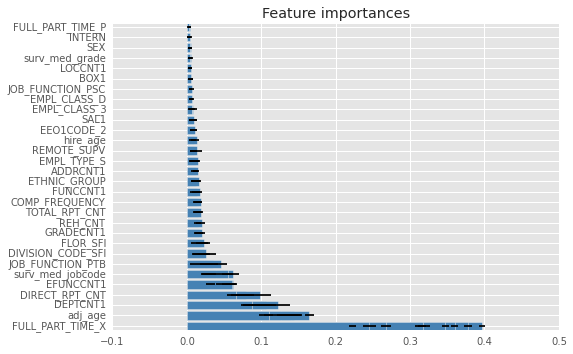

In [111]:
# push the feature importances to a dataframe
five_yr_rfB_fidf = create_fi_df(tfold_rf_mdlB,feature_names)

In [112]:
five_yr_rfB_fidf[['avg_val','avg_variance']].sort('avg_val',ascending=False)#.plot(kind='barh')

,avg_val,avg_variance
adj_age,3.017384e-01,8.998235e-02
DIRECT_RPT_CNT,1.123094e-01,2.835697e-02
JOB_FUNCTION_PTB,8.079218e-02,2.060916e-02
FULL_PART_TIME_X,8.071604e-02,8.190159e-02
DEPTCNT1,5.322035e-02,1.996691e-02
hire_age,4.790781e-02,3.413676e-02
SAL1,3.435014e-02,4.896364e-02
surv_med_jobcode,2.533845e-02,1.486176e-02
REH_CNT,2.201049e-02,9.577085e-03
GRADECNT1,1.769296e-02,2.105484e-03


In [113]:
## set up method to assess the eval set
print "There are {0} elements in the evaluation set".format(len(emEval))
## need to look who has terminated within 5 years
emEval.terminated.value_counts()

There are 20270 elements in the evaluation set


0    12853
1     7417
dtype: int64

In [114]:
#emEval_dates[emEval.terminated==1][['term_tstmp','hire_tstmp']]
eval_5yr_terminated_index = emEval[(emEval.terminated==1) & (emEval.Tenure_years <= 5.5)].index
#['Tenure_years']#['term_tstmp','hire_tstmp']]
# exclude indices that are active and have tenure less than this time
eval_5yr_excluded_index = emEval[(emEval.terminated==0) & (emEval.Tenure_years <= 5.5)].index
print len(eval_5yr_excluded_index),len(eval_5yr_terminated_index)
# the rest become my not-terminated set
eval_5yr_active_index = set(emEval.index) - set(eval_5yr_terminated_index) - set(eval_5yr_excluded_index)
print len(eval_5yr_active_index)

3073 4410
12787


In [115]:
eval_idx_to_use =emEval.ix[set(emEval.index)-set(eval_5yr_excluded_index)].index
len(eval_idx_to_use)
# reset the termination to 0 for active
eval_new_term = emEval.terminated.copy()
eval_new_term.ix[eval_5yr_active_index] = 0
print eval_new_term.ix[eval_idx_to_use].value_counts()
print "_____"
y5eval = eval_new_term.ix[eval_idx_to_use].as_matrix().astype(np.int) # true values

0    12787
1     4410
dtype: int64
_____


In [116]:
eval_adj_tenure = emEval.ix[eval_idx_to_use].Tenure_years.apply(lambda x: x-5 if (x>5.) else 0).values
len(eval_adj_tenure), len(y5eval)

(17197, 17197)

In [117]:
# if active reduce age by 5 otherwise use hire_age
eval_adj_age = emEval.ix[eval_idx_to_use].Age_years.apply(lambda x: x-5)
eval_adj_age.ix[eval_5yr_terminated_index] = emEval_dates['hire_age']


In [118]:
#trueEval = emEval.ix[eval_5yr_active_index].copy()
X5evalB = np.zeros((len(eval_idx_to_use),len(tfold_modeling_colsB)+2))
X5evalB[:,:-2] = emEval.ix[eval_idx_to_use][tfold_modeling_colsB].as_matrix().astype(np.float)
# now put the adjusted tenure and ages into this matrix
X5evalB[:,-2] = eval_adj_age.values
X5evalB[:,-1]=eval_adj_tenure


In [119]:
X5evalB[0,:]

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   3.87500000e+01,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         2.00000000e+01,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   9.99000000e+02,   5.58333333e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   5.57958069e+01,
         1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,

In [120]:
## now apply each model to my eval set
eval_prediction_class = np.zeros((len(X5evalB),len(tfold_rf_mdlB)))
eval_prediction_proba = np.zeros((len(X5evalB),2,len(tfold_rf_mdlB)))
for i,mdl in enumerate(tfold_rf_mdlB):
    eval_proba = mdl.predict_proba(X5evalB)
    eval_prediction_class[:,i]=mdl.predict(X5evalB)
    eval_prediction_proba[:,:,i]=eval_proba
print np.shape(eval_prediction_proba)

(17197, 2, 9)


In [121]:
metrics.roc_curve(y5eval,eval_prediction_proba[:,1,0])

(array([ 0.        ,  0.21740831,  0.22687104,  0.23304919,  0.23695941,
         0.23930554,  0.24149527,  0.24368499,  0.24548369,  0.24665676,
         0.24720419,  0.24845546,  0.24939392,  0.25119262,  0.2526003 ,
         0.25346055,  0.25432079,  0.25572847,  0.25690154,  0.25783999,
         0.25916947,  0.2597169 ,  0.26010792,  0.26112458,  0.26214124,
         0.26268867,  0.26370533,  0.2650348 ,  0.26612966,  0.2668335 ,
         0.26745914,  0.26800657,  0.2684758 ,  0.26925784,  0.26988348,
         0.27043091,  0.27113475,  0.2720732 ,  0.27254243,  0.27308986,
         0.27426292,  0.27457574,  0.27535779,  0.27613983,  0.27692187,
         0.2773911 ,  0.27793853,  0.27856417,  0.27926801,  0.27981544,
         0.2809103 ,  0.28130132,  0.28192696,  0.28247439,  0.28286541,
         0.28341284,  0.28380386,  0.28435129,  0.28474232,  0.28505513,
         0.28591538,  0.28615   ,  0.28669743,  0.28724486,  0.28779229,
         0.28826152,  0.28849613,  0.28912176,  0.2

In [122]:
eval_prediction_proba[:,:,:].mean(axis=2)

array([[ 0.05155556,  0.94844444],
       [ 0.19      ,  0.81      ],
       [ 0.00111111,  0.99888889],
       ..., 
       [ 0.        ,  1.        ],
       [ 0.70355556,  0.29644444],
       [ 0.        ,  1.        ]])

(0, 1.01)

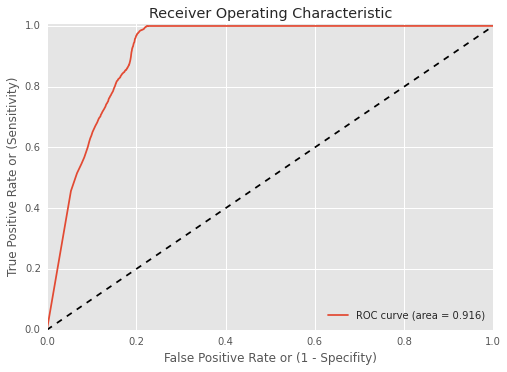

In [123]:
plot_roc_curve(y5eval,eval_prediction_proba[:,:,:].mean(axis=2))
plt.ylim([0,1.01])

In [131]:
#plot_conf_matrix(y5eval,map(np.int,eval_prediction_proba[:,:,0]),normed=False)

0.622768763685


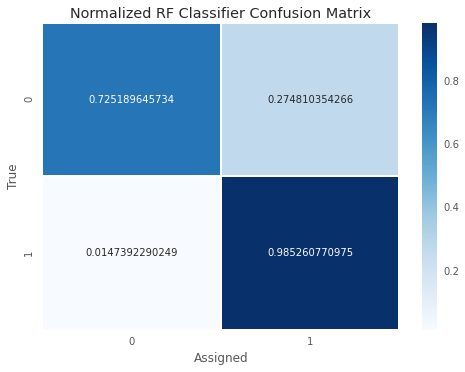

In [125]:
plot_conf_matrix(y5eval,map(int,eval_prediction_class.mean(axis=1)))#,normed=False)

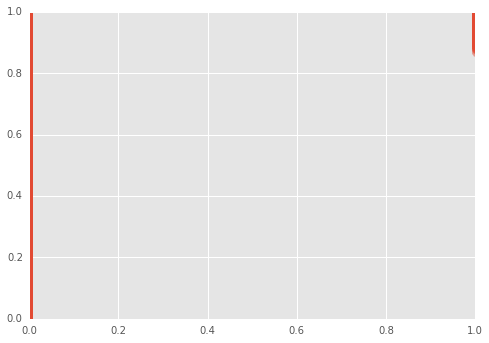

In [133]:
plt.plot(y5eval,eval_prediction_proba[:,1,:].mean(axis=1),'o',alpha=0.3)

## June 19,2015 Repeat for 3 year windows ??

In [126]:
three_yr_tfolds,three_yr_times = create_temporal_kfolds(emBuild_dates,full_date_range,3)

13 3 10 114863
11
2002-01-01 2005-01-01 66984 47879
2003-01-01 2006-01-01 64900 49963
2004-01-01 2007-01-01 61365 53498
2005-01-01 2008-01-01 58168 56695
2006-01-01 2009-01-01 56711 58152
2007-01-01 2010-01-01 56478 58385
2008-01-01 2011-01-01 55972 58891
2009-01-01 2012-01-01 56595 58268
2010-01-01 2013-01-01 55914 58949
2011-01-01 2014-01-01 54469 60394
2012-01-01 2015-01-01 53753 61110


In [127]:
threePanel = find_termination_within_x_years(emBuild_dates,emBuild,three_yr_times,three_yr_tfolds,3)


11
2002-01-01 2005-01-01 3
2003-01-01 2006-01-01 3
2004-01-01 2007-01-01 3
2005-01-01 2008-01-01 3
2006-01-01 2009-01-01 3
2007-01-01 2010-01-01 3
2008-01-01 2011-01-01 3
2009-01-01 2012-01-01 3
2010-01-01 2013-01-01 3
2011-01-01 2014-01-01 3
2012-01-01 2015-01-01 3


In [128]:
####
[x for x in tfold_modeling_colsB if x.startswith('unemp')]
tfold_modeling_colsB

['EMPL_CLASS_4',
 'EMPL_CLASS_5',
 'EMPL_CLASS_3',
 'FLSA_STATUS',
 'JOB_FUNCTION_NSA',
 'EEO1CODE_6',
 'EEO1CODE_7',
 'EEO1CODE_4',
 'RELOCATE_ALL_SFI',
 'EEO1CODE_3',
 'EEO1CODE_1',
 'STD_HOURS',
 'FLOORCNT1',
 'EEO1CODE_8',
 'EEO1CODE_N',
 'EEO1CODE_L',
 'FTPTCNT1',
 'EFUNCCNT1',
 'TOTAL_RPT_CNT',
 'EMPL_CLASS_T',
 'REMOTE',
 'SUPV_DIFF_LOC',
 'EMPL_CLASS_X',
 'EMPL_CLASS_G',
 'EMPL_CLASS_D',
 'FLOR_SFI',
 'surv_med_jobcode',
 'PERF1',
 'HUBIND',
 'JOB_FUNCTION_PSA',
 'JOB_FUNCTION_PSB',
 'JOB_FUNCTION_PSC',
 'RELO_STATE_CNT_SFI',
 'PTFTCNT1',
 'COMP_FREQUENCY',
 'hire_age',
 'HAVE_INS',
 'FTE',
 'JOB_FUNCTION_PTM',
 'JOB_FUNCTION_PTL',
 'JOB_FUNCTION_PTI',
 'JOB_FUNCTION_PTH',
 'JOB_FUNCTION_PTK',
 'JOB_FUNCTION_PTJ',
 'JOB_FUNCTION_PTE',
 'JOB_FUNCTION_PTD',
 'JOB_FUNCTION_PTG',
 'JOB_FUNCTION_PTF',
 'JOB_FUNCTION_PTA',
 'JOB_FUNCTION_PTC',
 'JOB_FUNCTION_PTB',
 'MAX_RT_ANNUAL',
 'LOCCNT1',
 'BOX1',
 'FUNCCNT1',
 'SUPVCNT1',
 'EMPL_TYPE_X',
 'SEX',
 'ETHNIC_GROUP',
 'DEP_COUNT',
 

In [129]:
#[(a,emBuild.ix[five_yr_tfolds[a][0]].terminated.sum()) for a in xrange(0,9)]
X3foldB = np.zeros((len(emBuild),len(tfold_modeling_colsB)+2,len(three_yr_tfolds)))
## So now
y3fold = []
for i in xrange(0,len(three_yr_tfolds)):
    X3foldB[:,:-2,i]=emBuild[tfold_modeling_colsB].as_matrix().astype(np.float)
    X3foldB[:,-2:,i]=threePanel[i][['adj_age','adj_tenure']]
    my_y=threePanel[i][['adj_term']].as_matrix().astype(np.int)
    y3fold.append(my_y)

In [130]:
%%time
threefold_rf_mdlB = []
for i in xrange(0,len(three_yr_tfolds)):
    train_y = y3fold[i].flatten()[three_yr_tfolds[i][0]]
    train_X = X3foldB[three_yr_tfolds[i][0],:,i]
    rfmdl = ensemble.RandomForestClassifier(n_jobs=50,n_estimators=500,max_features=None)
    rfmdl.fit(train_X,train_y)
#baseline_singleRFC = ensemble.RandomForestClassifier(n_jobs=50,n_estimators=500,max_features=None)
#baseline_singleRFC.fit(X,y_term)
#baseline_singleRFC_importances= baseline_singleRFC.feature_importances_
    threefold_rf_mdlB.append(rfmdl)

CPU times: user 2h 44min 37s, sys: 12.4 s, total: 2h 44min 49s
Wall time: 3min 33s


## assess 3 year windows

Number of Features: 90
Number of Trees: 500
Feature ranking:
1. feature 89=adj_age (0.335152)
2. feature 65=SAL1 (0.158592)
3. feature 73=REH_CNT (0.090289)
4. feature 80=DIRECT_RPT_CNT (0.064102)
5. feature 51=JOB_FUNCTION_PTB (0.042143)
6. feature 64=GRADECNT1 (0.036781)
7. feature 27=surv_med_jobcode (0.029390)
8. feature 84=EMPL_TYPE_S (0.027321)
9. feature 69=FULL_PART_TIME_X (0.025735)
10. feature 88=DEPTCNT1 (0.022194)
11. feature 18=TOTAL_RPT_CNT (0.018786)
12. feature 76=INTERN (0.016772)
13. feature 35=COMP_FREQUENCY (0.016087)
14. feature 79=DIVISION_CODE_SFI (0.013138)
15. feature 32=JOB_FUNCTION_PSC (0.009054)
16. feature 63=JOB_FUNCTION_MGT (0.008280)
17. feature 78=ADDRCNT1 (0.008049)
18. feature 26=FLOR_SFI (0.007520)
19. feature 53=LOCCNT1 (0.005906)
20. feature 36=hire_age (0.004186)
21. feature 52=MAX_RT_ANNUAL (0.004036)
22. feature 58=SEX (0.003800)
23. feature 55=FUNCCNT1 (0.003124)
24. feature 61=EEO1CODE_2 (0.002817)
25. feature 29=HUBIND (0.002687)
26. feature 

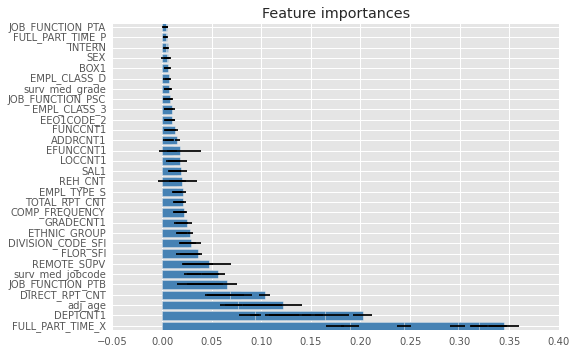

In [131]:
three_yr_rfB_fidf = create_fi_df(threefold_rf_mdlB,feature_names)
three_yr_rfB_fidf[['avg_val','avg_variance']].sort('avg_val',ascending=False).head(10)

In [132]:
three_yr_rfB_fidf[['avg_val','avg_variance']].sort('avg_val',ascending=False).head(10)


,avg_val,avg_variance
adj_age,0.276640,0.096813
DIRECT_RPT_CNT,0.099629,0.033846
JOB_FUNCTION_PTB,0.077805,0.026062
FULL_PART_TIME_X,0.069309,0.065211
SAL1,0.051280,0.072936
DEPTCNT1,0.045608,0.020072
hire_age,0.037501,0.029648
surv_med_jobcode,0.032786,0.011908
REH_CNT,0.026534,0.022050
GRADECNT1,0.025843,0.005975


In [133]:
#construct eval set for 3 years
## set up method to assess the eval set
print "There are {0} elements in the evaluation set".format(len(emEval))
## need to look who has terminated within 5 years
print "original terminated value counts:", emEval.terminated.value_counts()

There are 20270 elements in the evaluation set
original terminated value counts: 0    12853
1     7417
dtype: int64


In [134]:
#emEval_dates[emEval.terminated==1][['term_tstmp','hire_tstmp']]
yr_cut_val = 3.5
eval_3yr_terminated_index = emEval[(emEval.terminated==1) & (emEval.Tenure_years <= yr_cut_val)].index

# exclude indices that are active and have tenure less than this time
eval_3yr_excluded_index = emEval[(emEval.terminated==0) & (emEval.Tenure_years <= yr_cut_val)].index
print len(eval_3yr_excluded_index),len(eval_3yr_terminated_index)
# the rest become my not-terminated set
eval_3yr_active_index = set(emEval.index) - set(eval_3yr_terminated_index) - set(eval_3yr_excluded_index)
print len(eval_3yr_active_index)

2791 3515
13964


In [135]:
eval_idx_to_use3 =emEval.ix[set(emEval.index)-set(eval_3yr_excluded_index)].index
len(eval_idx_to_use3)
# reset the termination to 0 for active
eval_new_term3 = emEval.terminated.copy()
eval_new_term3.ix[eval_3yr_active_index] = 0
print eval_new_term3.ix[eval_idx_to_use3].value_counts()
print "_____"
y3eval = eval_new_term3.ix[eval_idx_to_use3].as_matrix().astype(np.int) # true values
eval_adj_tenure3 = emEval.ix[eval_idx_to_use3].Tenure_years.apply(lambda x: x-3 if (x>3.) else 0).values
len(eval_adj_tenure3), len(y3eval)

0    13964
1     3515
dtype: int64
_____


(17479, 17479)

In [136]:
# if active reduce age by 5 otherwise use hire_age
eval_adj_age3 = emEval.ix[eval_idx_to_use3].Age_years.apply(lambda x: x-3)
eval_adj_age3.ix[eval_3yr_terminated_index] = emEval_dates['hire_age']


In [137]:
#trueEval = emEval.ix[eval_5yr_active_index].copy()
X3evalB = np.zeros((len(eval_idx_to_use3),len(tfold_modeling_colsB)+2))
X3evalB[:,:-2] = emEval.ix[eval_idx_to_use3][tfold_modeling_colsB].as_matrix().astype(np.float)
# now put the adjusted tenure and ages into this matrix
X3evalB[:,-2] = eval_adj_age3.values
X3evalB[:,-1]=eval_adj_tenure3

In [138]:
## now apply each model to my eval set
eval_prediction_class3 = np.zeros((len(X3evalB),len(threefold_rf_mdlB)))
eval_prediction_proba3 = np.zeros((len(X3evalB),2,len(threefold_rf_mdlB)))
for i,mdl in enumerate(threefold_rf_mdlB):
    eval_proba = mdl.predict_proba(X3evalB)
    eval_prediction_class3[:,i]=mdl.predict(X3evalB)
    eval_prediction_proba3[:,:,i]=eval_proba
print np.shape(eval_prediction_proba3)

(17479, 2, 11)


0.738525673317


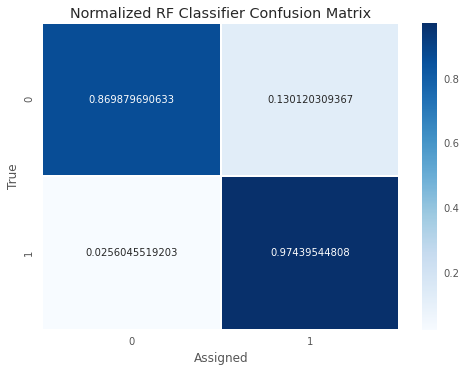

In [139]:
plot_conf_matrix(y3eval,map(np.int,eval_prediction_class3.mean(axis=1)))

(0, 1.01)

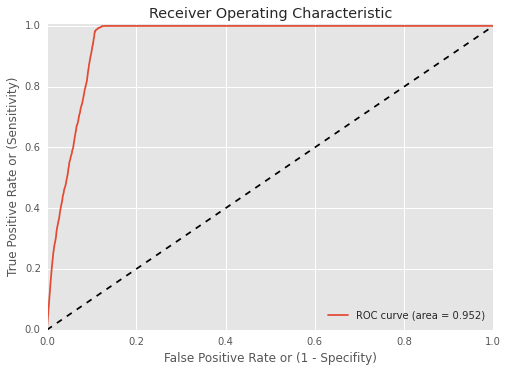

In [140]:
#plot_roc_curve(y3eval,eval_prediction_proba3[:,])
plot_roc_curve(y3eval,eval_prediction_proba3[:,:,:].mean(axis=2))
plt.ylim([0,1.01])

In [143]:
np.shape(threefold_rf_mdlB[-1].transform(train_X))

(53753, 20)

## July 7, 2015
* reimplement this into a function based upon time frame
* build out pipe lines
* notes from Bear:
    * DimensionReduction is a class that does dimension reduction use PCA or LDA, default is PCA
    * ModelPredictor is a class that will give prediction of probability using different models with different parameters the order of classes matters.
    * add rows_to_scan can gain more speed when the dataset is large in these situations, only the first portion of data will be scanned for fitting.
    * Note that the rows_to_scan will always scan from the first observation one by one, so shuffling the data may be done before
```
from sklearn.pipeline import Pipeline
cate_list = br.get_categorical_list(X)
pipe = Pipeline([("null", br.RemoveAllNull()),                   
                 ("cat", br.ConvertCategorical(cate_list, rows_to_scan=0.3)),
                 ("fixout", br.FixNumericOutlier(rows_to_scan=0.3)),
                 ("imp", br.ImputeData(columns_to_impute='auto', rows_to_scan=0.3)),
                 ("log", br.LogTrans()),
                 ("res", br.RescaleData(rows_to_scan=0.3)),
                 ("inter", br.AddInteraction()),
                 ("redu", br.DimensionReduction(rows_to_scan=0.3)),                 
                 ("modelpred", br.ModelPredictor())])
                 ````

In [144]:
def define_target_within_x_years(dates_df,df,paired_dates,tfold,n_years,target_col):
    print len(tfold)#, paired_dates

    df_dict = {}
    for i,tf in enumerate(tfold):
        start_date = paired_dates[i][0]
        end_date = paired_dates[i][1]
        print start_date,end_date,n_years
        #altered_fold_df = pd.DataFrame(columns=['fold_mbr','adj_age','adj_tenure','adj_term'])
        # if in the fold reset the age to start of fold; define new window of termination
        in_fold_idx = tfold[i][0]
        # note that "sex" is just used to create a value that then gets dummied out
        cols_to_copy = ['SEX','Age_years','Tenure_years']
        cols_to_copy.append(target_col)
        #altered_fold_df= df[['SEX','Age_years','Tenure_years','terminated']].copy()
        altered_fold_df = df[cols_to_copy].copy()
        # adjust these
        altered_fold_df.columns=['fold_mbr','adj_age','adj_tenure','adj_term']
        altered_fold_df.fold_mbr = 0

        ra,rt = reset_years(paired_dates,in_fold_idx,dates_df,df)
        altered_fold_df.ix[in_fold_idx]['adj_age']=ra
        altered_fold_df.ix[in_fold_idx]['adj_tenure']=rt
        new_term = (dates_df.ix[in_fold_idx]['term_tstmp']<= end_date).as_matrix().astype(np.int)
        # deal with last time-fold specially
        if i == len(tfold)-1:
            new_term = (dates_df.ix[in_fold_idx]['term_tstmp']< end_date).as_matrix().astype(np.int)
        #print "\t", len(new_term),sum(new_term)
        altered_fold_df.loc[in_fold_idx,'adj_term']=new_term
        altered_fold_df.loc[in_fold_idx,'fold_mbr']=1
        df_dict[i]=altered_fold_df
    # now append this to a larger panel
    tfold_panel = pd.Panel.from_dict(data =df_dict)
    return tfold_panel

In [145]:
threePanelterm_b = define_target_within_x_years(emBuild_dates,emBuild,three_yr_times,three_yr_tfolds,3,'terminated')

11
2002-01-01 2005-01-01 3
2003-01-01 2006-01-01 3
2004-01-01 2007-01-01 3
2005-01-01 2008-01-01 3
2006-01-01 2009-01-01 3
2007-01-01 2010-01-01 3
2008-01-01 2011-01-01 3
2009-01-01 2012-01-01 3
2010-01-01 2013-01-01 3
2011-01-01 2014-01-01 3
2012-01-01 2015-01-01 3


In [154]:
for i in xrange(0,11):
    print i, (threePanelterm_b[i]-threePanel[i]).sum().sum() ## the in put data is the same.

0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0


In [ ]:
empl

In [228]:
[a for a in modeling_cols_2 if a.startswith('FULL_')]

['FULL_PART_TIME_N', 'FULL_PART_TIME_X', 'FULL_PART_TIME_P']

In [224]:
from sklearn import tree
print len(threefold_rf_mdlB[0].estimators_)
threefold_rf_mdlB[0].estimators_[0].feature_importances_


500


array([  4.21891595e-04,   0.00000000e+00,   5.42743874e-04,
         8.26775676e-04,   2.37113037e-03,   6.69605978e-05,
         1.69763032e-04,   2.01232702e-04,   6.36344243e-04,
         3.39676556e-04,   1.17306249e-03,   8.39213228e-04,
         1.47651222e-04,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   1.15117152e-04,   4.24460798e-04,
         1.59803414e-02,   0.00000000e+00,   1.11310240e-04,
         6.90272023e-04,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   2.05839740e-03,   7.84358388e-03,
         2.67421524e-02,   1.93626516e-03,   1.31390652e-03,
         3.31293074e-03,   7.39696537e-04,   9.25825574e-03,
         0.00000000e+00,   1.26702072e-04,   1.80008944e-02,
         6.91531611e-03,   6.96034201e-04,   0.00000000e+00,
         0.00000000e+00,   2.20568625e-04,   3.70592022e-04,
         0.00000000e+00,   0.00000000e+00,   2.22222460e-04,
         3.95938376e-06,   1.81778448e-04,   9.00684607e-04,
         5.98260324e-04,

In [227]:
#threefold_rf_mdlB[0].transform(X3foldB[0])

ValueError: X has different number of features than during model fitting.

## APPLY to 1 year windows

In [155]:
one_yr_tfolds,one_yr_times = create_temporal_kfolds(emBuild_dates,full_date_range,1)

13 1 12 114863
13
2002-01-01 2003-01-01 66984 47879
2003-01-01 2004-01-01 64900 49963
2004-01-01 2005-01-01 61365 53498
2005-01-01 2006-01-01 58168 56695
2006-01-01 2007-01-01 56711 58152
2007-01-01 2008-01-01 56478 58385
2008-01-01 2009-01-01 55972 58891
2009-01-01 2010-01-01 56595 58268
2010-01-01 2011-01-01 55914 58949
2011-01-01 2012-01-01 54469 60394
2012-01-01 2013-01-01 53753 61110
2013-01-01 2014-01-01 56017 58846
2014-01-01 2015-01-01 58763 56100


In [156]:
onePanelterm = define_target_within_x_years(emBuild_dates,emBuild,one_yr_times,one_yr_tfolds,1,'terminated')

13
2002-01-01 2003-01-01 1
2003-01-01 2004-01-01 1
2004-01-01 2005-01-01 1
2005-01-01 2006-01-01 1
2006-01-01 2007-01-01 1
2007-01-01 2008-01-01 1
2008-01-01 2009-01-01 1
2009-01-01 2010-01-01 1
2010-01-01 2011-01-01 1
2011-01-01 2012-01-01 1
2012-01-01 2013-01-01 1
2013-01-01 2014-01-01 1
2014-01-01 2015-01-01 1


In [158]:
#[(a,emBuild.ix[five_yr_tfolds[a][0]].terminated.sum()) for a in xrange(0,9)]
X1foldB = np.zeros((len(emBuild),len(tfold_modeling_colsB)+2,len(one_yr_tfolds)))
## So now
y1fold = []
for i in xrange(0,len(one_yr_tfolds)):
    X1foldB[:,:-2,i]=emBuild[tfold_modeling_colsB].as_matrix().astype(np.float)
    X1foldB[:,-2:,i]=onePanelterm[i][['adj_age','adj_tenure']]
    my_y=onePanelterm[i][['adj_term']].as_matrix().astype(np.int)
    y1fold.append(my_y)

In [160]:
%%time
onefold_rf_mdlB = []
for i in xrange(0,len(one_yr_tfolds)):
    train_y = y1fold[i].flatten()[one_yr_tfolds[i][0]]
    train_X = X1foldB[one_yr_tfolds[i][0],:,i]
    rfmdl = ensemble.RandomForestClassifier(n_jobs=50,n_estimators=500,max_features=None)
    rfmdl.fit(train_X,train_y)
#baseline_singleRFC = ensemble.RandomForestClassifier(n_jobs=50,n_estimators=500,max_features=None)
#baseline_singleRFC.fit(X,y_term)
#baseline_singleRFC_importances= baseline_singleRFC.feature_importances_
    onefold_rf_mdlB.append(rfmdl)

CPU times: user 3h 13min 29s, sys: 14.6 s, total: 3h 13min 44s
Wall time: 4min 11s


## Assess Models

Number of Features: 90
Number of Trees: 500
Feature ranking:
1. feature 73=REH_CNT (0.751110)
2. feature 89=adj_age (0.054284)
3. feature 63=JOB_FUNCTION_MGT (0.019833)
4. feature 76=INTERN (0.019174)
5. feature 88=DEPTCNT1 (0.016958)
6. feature 64=GRADECNT1 (0.015368)
7. feature 80=DIRECT_RPT_CNT (0.012557)
8. feature 51=JOB_FUNCTION_PTB (0.009529)
9. feature 27=surv_med_jobcode (0.008586)
10. feature 35=COMP_FREQUENCY (0.008451)
11. feature 84=EMPL_TYPE_S (0.007395)
12. feature 65=SAL1 (0.007121)
13. feature 61=EEO1CODE_2 (0.006862)
14. feature 3=FLSA_STATUS (0.006260)
15. feature 18=TOTAL_RPT_CNT (0.004645)
16. feature 83=EMPL_TYPE_N (0.004510)
17. feature 0=EMPL_CLASS_4 (0.004141)
18. feature 69=FULL_PART_TIME_X (0.003828)
19. feature 79=DIVISION_CODE_SFI (0.003636)
20. feature 26=FLOR_SFI (0.003321)
21. feature 78=ADDRCNT1 (0.003318)
22. feature 53=LOCCNT1 (0.002349)
23. feature 32=JOB_FUNCTION_PSC (0.002347)
24. feature 30=JOB_FUNCTION_PSA (0.001989)
25. feature 60=DEP_COUNT (0.0

,avg_val,avg_variance
adj_age,0.228764,0.075931
DIRECT_RPT_CNT,0.080742,0.060236
REH_CNT,0.076089,0.202898
JOB_FUNCTION_PTB,0.061154,0.034269
FULL_PART_TIME_X,0.054968,0.024997
DEPTCNT1,0.044093,0.013173
surv_med_jobcode,0.041342,0.014195
GRADECNT1,0.037130,0.010855
SAL1,0.034765,0.056248
COMP_FREQUENCY,0.031221,0.008726


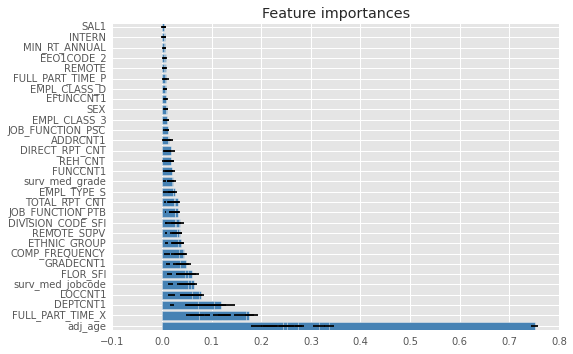

In [161]:
one_yr_rfB_fidf = create_fi_df(onefold_rf_mdlB,feature_names)
one_yr_rfB_fidf[['avg_val','avg_variance']].sort('avg_val',ascending=False).head(10)

In [192]:
one_yr_rfB_fidf.head()

,fold0_value,fold0_std,fold1_value,fold1_std,fold2_value,fold2_std,fold3_value,fold3_std,fold4_value,fold4_std,...,fold9_value,fold9_std,fold10_value,fold10_std,fold11_value,fold11_std,fold12_value,fold12_std,avg_val,avg_variance
ADDRCNT1,0.003318,0.001609,0.014997,0.004017,0.016720,0.004442,0.022402,0.005156,0.018695,0.003486,...,0.012332,0.003029,0.020010,0.005029,0.010086,0.003443,0.012187,0.003072,0.014207,0.004871
BOX1,0.000350,0.000449,0.001103,0.000654,0.000683,0.000537,0.000482,0.000423,0.000949,0.000851,...,0.014030,0.003356,0.008835,0.006035,0.019198,0.005491,0.002956,0.001164,0.003959,0.006150
COMP_FREQUENCY,0.008451,0.001966,0.036898,0.003705,0.029194,0.003346,0.031583,0.003702,0.039615,0.004656,...,0.031592,0.004889,0.026973,0.004695,0.019827,0.003552,0.034463,0.004097,0.031221,0.008726
DEPTCNT1,0.016958,0.005702,0.037655,0.004081,0.034506,0.003850,0.036201,0.004562,0.052399,0.005199,...,0.058680,0.006548,0.044710,0.005673,0.040064,0.005370,0.071983,0.004820,0.044093,0.013173
DEP_COUNT,0.001705,0.001386,0.007620,0.003964,0.001387,0.000927,0.000951,0.000678,0.001964,0.001421,...,0.001802,0.001433,0.002551,0.003470,0.001531,0.001779,0.001117,0.000760,0.002162,0.001689


In [199]:
one_yr_rfB_fidf['avg_val'].head(20)#.sort('avg_val',ascending=False).head(20)#.T.boxplot(rot=30)#(kind='bar')

ADDRCNT1             1.420715e-02
BOX1                 3.959102e-03
COMP_FREQUENCY       3.122069e-02
DEPTCNT1             4.409256e-02
DEP_COUNT            2.161936e-03
DIRECT_RPT_CNT       8.074227e-02
DIVISION_CODE_SFI    2.380006e-02
EEO1CODE_1           8.269838e-04
EEO1CODE_2           5.981404e-03
EEO1CODE_3           4.716342e-03
EEO1CODE_4           1.368670e-03
EEO1CODE_6           7.239910e-04
EEO1CODE_7           4.816478e-04
EEO1CODE_8           0.000000e+00
EEO1CODE_L           1.655744e-05
EEO1CODE_N           2.680286e-06
EFUNCCNT1            3.241211e-03
EMPL_CLASS_3         2.068530e-03
EMPL_CLASS_4         4.190643e-04
EMPL_CLASS_5         7.352836e-07
Name: avg_val, dtype: float64

In [184]:
#
def adjust_eval_by_x_years(df,df_dates,year_val,modeling_columns,target_col='terminated'):
    # construct
  
    ## set up method to assess the eval set
    print "There are {0} elements in the evaluation set".format(len(df))
   
    print "original target variable value counts:", df[target_col].value_counts()
    # restructure to deal with time_frame retirement (target variable)
    yr_cut_val = year_val+0.5
    # index of those that actually accomplish target within timeframe (allow 0.5 additional years)
    eval_within_time_target_index = df[(df[target_col]==1) & (df.Tenure_years <= yr_cut_val)].index
    # exclude indices that are active and have tenure less than this time
    eval_excluded_index = df[(df[target_col]==0) & (df.Tenure_years  <= yr_cut_val)].index
    
    # the rest become my not-terminated set
    eval_active_index = set(df.index) - set(eval_within_time_target_index) - set(eval_excluded_index)
    print len(eval_excluded_index),len(eval_within_time_target_index), len(eval_active_index)
    eval_idx_to_use =df.ix[set(df.index)-set(eval_excluded_index)].index
    #len(eval_idx_to_use)
    # reset the termination to 0 for active
    eval_new_target = df[target_col].copy()
    eval_new_target.ix[eval_active_index] = 0
    print "new target variable value counts: "
    print eval_new_target.ix[eval_idx_to_use].value_counts()
    print "_____"
    y_eval = eval_new_target.ix[eval_idx_to_use].as_matrix().astype(np.int) # true values
    eval_adj_tenure = df.ix[eval_idx_to_use].Tenure_years.apply(lambda x: x-year_val if (x>float(year_val)) else 0).values
    print len(eval_adj_tenure), len(y_eval)
    # now adjust age by length of time; use hire_age if not in set to use.
    eval_adj_age = df.ix[eval_idx_to_use].Age_years.apply(lambda x: x-year_val)
    eval_adj_age.ix[eval_within_time_target_index] = df_dates['hire_age']
    
    # construct the evaluation X matrix
    print "input matrix has {0} features".format(len(modeling_columns)+2)
    Xeval = np.zeros((len(eval_idx_to_use),len(modeling_columns)+2))
    Xeval[:,:-2] = df.ix[eval_idx_to_use][modeling_columns].as_matrix().astype(np.float)
    # now put the adjusted tenure and ages into this matrix
    Xeval[:,-2] = eval_adj_age.values
    Xeval[:,-1]=eval_adj_tenure
    #print len(modeling_columns),np.shape(Xeval)
    return Xeval, y_eval


## now apply each model to my eval set
def evaluate_models(model_list,Xeval):
    eval_pred_class = np.zeros((len(Xeval),len(model_list)))
    eval_pred_proba = np.zeros((len(Xeval),2,len(model_list)))

    for i,mdl in enumerate(model_list):
        eval_proba = mdl.predict_proba(Xeval)
        eval_pred_class[:,i]=mdl.predict(Xeval)
        eval_pred_proba[:,:,i]=eval_proba
    #print np.shape(eval_prediction_proba3)
    return eval_pred_class, eval_pred_proba

In [185]:
X1eval, y1eval = adjust_eval_by_x_years(emEval,emEval_dates,1,modeling_columns=tfold_modeling_colsB,target_col='terminated')

There are 20270 elements in the evaluation set
original target variable value counts: 0    12853
1     7417
dtype: int64
1533 2210 16527
new target variable value counts: 
0    16527
1     2210
dtype: int64
_____
18737 18737
input matrix has 90 features


In [186]:
np.shape(X1eval), onefold_rf_mdlB[0], len(tfold_modeling_colsB)

((18737, 90),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=50,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 88)

In [187]:
eval_pred_class1,eval_pred_proba1 = evaluate_models(onefold_rf_mdlB,X1eval)

0.376967529136


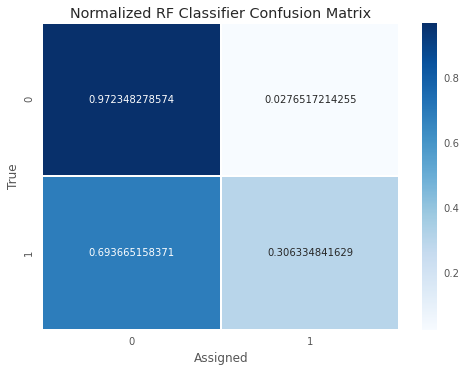

In [189]:
plot_conf_matrix(y1eval,map(np.int,eval_pred_class1.mean(axis=1)))

0.376967529136


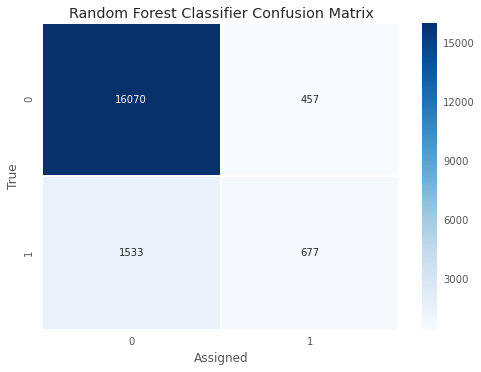

In [191]:
plot_conf_matrix(y1eval,map(np.int,eval_pred_class1.mean(axis=1)),normed=False)

(0, 1.01)

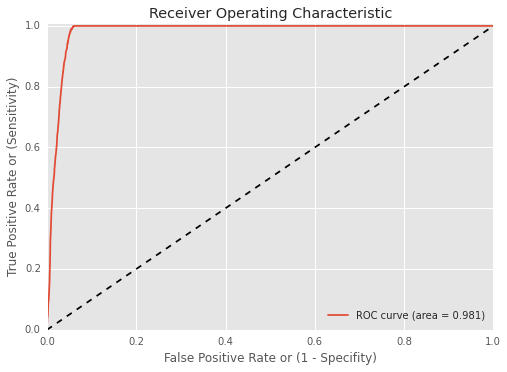

In [190]:
#plot_roc_curve(y3eval,eval_prediction_proba3[:,])
plot_roc_curve(y1eval,eval_pred_proba1[:,:,:].mean(axis=2))
plt.ylim([0,1.01])

In [ ]:
X

## June 29, 2015
* look at retirement??

In [151]:
####
[x for x in tfold_modeling_colsB if x.startswith('termin')]

[]

In [154]:
threePanelret = define_target_within_x_years(emBuild_dates,emBuild,three_yr_times,three_yr_tfolds,3,'retired')

11
2002-01-01 2005-01-01 3
2003-01-01 2006-01-01 3
2004-01-01 2007-01-01 3
2005-01-01 2008-01-01 3
2006-01-01 2009-01-01 3
2007-01-01 2010-01-01 3
2008-01-01 2011-01-01 3
2009-01-01 2012-01-01 3
2010-01-01 2013-01-01 3
2011-01-01 2014-01-01 3
2012-01-01 2015-01-01 3


In [155]:
#[(a,emBuild.ix[five_yr_tfolds[a][0]].terminated.sum()) for a in xrange(0,9)]
X3foldBret = np.zeros((len(emBuild),len(tfold_modeling_colsB)+2,len(three_yr_tfolds)))
## So now
y3foldret = []
for i in xrange(0,len(three_yr_tfolds)):
    X3foldBret[:,:-2,i]=emBuild[tfold_modeling_colsB].as_matrix().astype(np.float)
    X3foldBret[:,-2:,i]=threePanelret[i][['adj_age','adj_tenure']]
    my_y=threePanelret[i][['adj_term']].as_matrix().astype(np.int)
    y3foldret.append(my_y)

In [156]:
%%time
threefold_rf_mdlBret = []
for i in xrange(0,len(three_yr_tfolds)):
    train_y = y3foldret[i].flatten()[three_yr_tfolds[i][0]]
    train_X = X3foldBret[three_yr_tfolds[i][0],:,i]
    rfmdl = ensemble.RandomForestClassifier(n_jobs=50,n_estimators=500,max_features=None)
    rfmdl.fit(train_X,train_y)
#baseline_singleRFC = ensemble.RandomForestClassifier(n_jobs=50,n_estimators=500,max_features=None)
#baseline_singleRFC.fit(X,y_term)
#baseline_singleRFC_importances= baseline_singleRFC.feature_importances_
    threefold_rf_mdlBret.append(rfmdl)

CPU times: user 2h 41min 9s, sys: 13 s, total: 2h 41min 22s
Wall time: 3min 28s


In [161]:
def fix_eval_df(eval_df, eval_dates, tfold_year_value,modeling_cols,target_col='terminated'):
    yr_cut_val = tfold_year_value+0.5
    # get the indices from the evaluation data frame that have target_column value of 1 and Tenure less than the time window size.

    eval_target_index = eval_df[(eval_df[target_col]==1) & (eval_df['Tenure_years']<=yr_cut_val)].index
    # exclude indices that are active and have tenure less than this time
    eval_excluded_index = eval_df[(eval_df[target_col]==0) & (eval_df['Tenure_years'] <= yr_cut_val)].index
    print len(eval_excluded_index),len(eval_target_index)
    # the rest become my not-terminated set
    eval_included_index = set(eval_df.index) - set(eval_target_index) - set(eval_excluded_index)
    eval_idx_to_use = eval_df.ix[set(eval_df.index) - set(eval_excluded_index)].index #emEval.index)-set(eval_3yr_excluded_index)].index
    len(eval_idx_to_use)
    # reset the termination to 0 for active
    eval_new_target = eval_df[target_col].copy()
    eval_new_target.ix[eval_included_index] = 0
    print eval_new_target.ix[eval_idx_to_use].value_counts()
    print "_____"
    y_eval_tgt = eval_new_target.ix[eval_idx_to_use].as_matrix().astype(np.int) # true values
    eval_adj_tgt = eval_df.ix[eval_idx_to_use].Tenure_years.apply(lambda x: x-tfold_year_value if (x > np.float(tfold_year_value)) else 0).values
    print len(eval_adj_tenure3), len(y3eval)
    eval_adj_age = eval_df.ix[eval_idx_to_use].Age_years.apply(lambda x: x- tfold_year_value)
    eval_adj_age.ix[eval_target_index] = eval_dates['hire_age']
    Xeval = np.zeros((len(eval_idx_to_use),len(modeling_cols)+2))
    Xeval[:,:-2] = eval_df.ix[eval_idx_to_use][modeling_cols].as_matrix().astype(np.float)
    Xeval[:,-2] = eval_adj_age.values
    Xeval[:,-1]=eval_adj_tgt

    return Xeval,y_eval_tgt

In [162]:
eval_3Xbret, y_eval_3_ret = fix_eval_df(emEval, emEval_dates, 3,tfold_modeling_colsB, target_col = 'retired')#modeling_cols,target_col='terminated')

6285 3
0    13982
1        3
dtype: int64
_____
17526 17526


In [165]:
emEval.retired.value_counts()

0    17981
1     2289
dtype: int64

In [ ]:
# Create a set of those who are separated only
emB_build = emSets[1][emSets[1][reduced_cols].status ==1].copy()
emB_active = emSets[1][emSets[1][reduced_cols].status==0].copy()

In [ ]:
emB_build.terminated.value_counts(), emB_build.retired.value_counts()

In [ ]:
len(emB_build)

In [ ]:
emB_build.terminated.value_counts()/float(len(emB_build))

In [ ]:

emB_build.Tenure_years.describe()

In [ ]:
tenure_years_range= [0.0,65.0]
emB_build.Tenure_years.hist(bins=66,range=tenure_years_range)

In [ ]:
y_tenure_class = pd.cut(emB_build.Tenure_years,[0,1,2,3,4,5,6,7,8,200],labels=False,right=False)#,labels=[1,2,3,4,5,6,7,8])#.values

In [ ]:
pd.value_counts(y_tenure_class).plot(kind='bar')#.reindex(y_tenure_class.levels)

In [ ]:
# create evaluation set and test set
from sklearn import cross_validation
eval_fraction = 0.15
emB, emB_eval = cross_validation.train_test_split(emB_build,test_size=eval_fraction)

In [ ]:
train_index = emB.index.tolist()
eval_index = emB_eval.index.tolist()


In [ ]:
y_tenure_class.ix[eval_index].value_counts()/float(len(eval_index))

In [ ]:
y_tenure_class.ix[train_index].value_counts()/float(len(train_index))

In [ ]:
high_collinear_cols = ['EMPL_CLASS_P','EMPL_CLASS_O','EEO1CODE_9']
mos_columns = [x for x in reduced_cols if x.endswith('MOS')]
other_cols_to_drop = ['status','sep_status','EXTFUNC_CNT','EXT_FUNC_ID_SFI','FUNC_CNT','FUNC_ID_SFI','retired','terminated','Tenure_years']
modeling_cols = list(set(reduced_cols)-set(high_collinear_cols)-set(other_cols_to_drop)-set(mos_columns))
print len(reduced_cols), len(modeling_cols)

In [ ]:
X = emB[modeling_cols].as_matrix().astype(np.float)
print np.shape(X)
y_tenure = emB.Tenure_years.as_matrix().astype(np.float)

In [ ]:
Xeval = emB_eval[modeling_cols].as_matrix().astype(np.float)
yeval_tenure = emB_eval.Tenure_years.as_matrix().astype(np.float)

In [ ]:
%%time 
forest = ensemble.RandomForestClassifier(n_jobs=50,n_estimators=500,max_features=None)
forest.fit(X,y_tenure_class.ix[train_index])
importances= forest.feature_importances_

In [ ]:
y_pred_tenure_class = forest.predict(Xeval)
rfc_tenureclass_conf_matrix = metrics.confusion_matrix(y_tenure_class.ix[eval_index],y_pred_tenure_class)
sns.heatmap(rfc_tenureclass_conf_matrix, annot=True,  fmt='',cmap='Blues')#
plt.title('Random Forest Classifier Confusion Matrix')

In [ ]:
graph_feature_importances(forest,modeling_cols)

In [ ]:
plotFI(forest,modeling_cols)

In [ ]:
tree.export_graphviz(forest[0],out_file='tree.dot')

In [ ]:
import pydot as pyd
#import fig_code

In [ ]:
f0_graph = pyd.graph_from_dot_file('tree.dot')

In [ ]:
f0_graph

In [ ]:
X_active = emB_active[modeling_cols].as_matrix().astype(np.float)

In [ ]:
tenure_years_predict_proba_active = forest.predict_proba(X_active)
np.shape(tenure_years_predict_proba_active)

In [ ]:
tenure_years_predict_proba_active[:,0]
forest.predict(X_active)

In [ ]:
emB_active.Tenure_years

## Maybe Regressor is better approach?

In [ ]:
%%time 
RFRforest = ensemble.RandomForestRegressor(n_jobs=50,n_estimators=500,max_features=None)
RFRforest.fit(X,y_tenure)
#importances= forest.feature_importances_

In [ ]:
plotFI(RFRforest,modeling_cols)

In [ ]:
## apply to the eval subset from emB
pred_tenure_eval = RFRforest.predict(Xeval)
np.shape(pred_tenure_eval), np.shape(y_tenure_class.ix[eval_index])
#rfc_tenureclass_conf_matrix = metrics.confusion_matrix(y_tenure_class.ix[eval_index],y_pred_tenure_class)
#sns.heatmap(rfc_tenureclass_conf_matrix, annot=True,  fmt='',cmap='Blues')#
#plt.title('Random Forest Classifier Confusion Matrix')
#predict_tenure_ = forest.predict_proba(X_eval)
#np.shape(tenure_years_predict_proba_active)

In [ ]:
from sklearn import linear_model

In [ ]:
# return a linear regression fit of some data
def linear_reg_fit(x,y,n_samples = 50, verbose=False):
    import statsmodels.api as sm
    # create the x_prime variable
    x_prime = np.linspace(x.min(),x.max(),n_samples)[:,np.newaxis]
    # add a constant to the predictor
    x = sm.add_constant(x)# Adds a constant term to the predictor
    # create linear regression object
    ols = sm.OLS(y, x)
    est = ols.fit()
    if verbose:
        print est.summary()
    x_prime = sm.add_constant(x_prime)  # add constant as we did before

    # Now we calculate the predicted values
    y_hat = est.predict(x_prime)
   
    #print "\n ====================== \n"
    coef = est.params[1]
    rsquared = est.rsquared
    return x_prime[:,1],y_hat, coef,rsquared

In [ ]:
ols=linear_model.LinearRegression()


In [ ]:
x_p,y_p = linear_reg_fit(emB_eval.Tenure_years.values, pred_tenure_eval)#,pred_tenure_eval)


In [ ]:
x_p

In [ ]:
#plt.scatter(y_tenure_class.ix[eval_index],pred_tenure_eval,color='chartreuse',alpha=0.3)
sns.regplot(emB_eval.Tenure_years, pred_tenure_eval,color='darkslategray')
#plt.scatter(emB_eval.Tenure_years,pred_tenure_eval,color='darkslategray',alpha=0.3)
plt.xlabel('True Tenure Length')
plt.ylabel('Predicted Tenure Length')
# Create linear regression object
#x_p,y_p,coef = linear_reg_fit(emB_eval.Tenure_years.values, pred_tenure_eval)



# Plot linear fit


In [ ]:
#plt.scatter(y_tenure_class.ix[eval_index],pred_tenure_eval,color='chartreuse',alpha=0.3)
plt.scatter(emB_eval.Tenure_years,pred_tenure_eval,color='darkslategray',alpha=0.3)
plt.xlabel('True Tenure Length')
plt.ylabel('Predicted Tenure Length')
plt.xlim([0,10])
plt.ylim([0,10])

In [ ]:
### so this result is 'nice' however it still doesn't translate well going forward with the active employees.
#### Issues
1. wide band/scatter
2. Not really predictive
#### Solution?
1. return to time-segmenting the data

## look at the effect of replacing job_fcode or JOBCODE by the median survival tenure

In [ ]:
print "input dataset emB_build (length of {0}) is split into an evaluation set (length = {1}) and training set (length = {2})".format(len(emB_build),len(emB_eval), len(emB))
print "there are {0} unique values of JOBCODE.".format(len(emB_build.JOBCODE.unique()))

In [ ]:
jobcode_emB_vc = emB_build.JOBCODE.value_counts()
.005*len(emB_build)

In [ ]:
len(jobcode_emB_vc[jobcode_emB_vc>400])

In [ ]:
from lifelines import KaplanMeierFitter

In [ ]:
# creat groups
jobcode_grps = jobcode_emB_vc.ix[:40].index.tolist() # over 400 members
jobcode_grp_dict = {} # make a list of elements in each of these groups
for grp in jobcode_grps:
    jobcode_grp_dict[grp] = emB_build[emB_build.JOBCODE == grp].index.tolist()


In [ ]:
#65*12 - 0
mthl_tenure_range = np.linspace(0,65,781)
mthl_tenure_range

In [ ]:
emB_build.ix[jf_idx].Tenure_years #= jobcjgrp

In [ ]:
kmf_jobcode.fit(emB_build.Tenure_years.ix[j_idx],event_observed=emB_build.ix[j_idx].terminated,timeline=mthl_tenure_range,label=str(jgrp))

In [ ]:
kmf_jobcode = KaplanMeierFitter()
kmf_jobcode.fit(emB_build.Tenure_years,timeline=mthl_tenure_range, event_observed=emB_build.terminated,label='all')
jobcode_sf_df = pd.DataFrame(kmf_jobcode.survival_function_)
for i,jgrp in enumerate(jobcode_grps):
    j_idx = jobcode_grp_dict[jgrp]
    print i, jgrp, len(j_idx)
    kmf_jobcode.fit(emB_build.Tenure_years.ix[j_idx],timeline=mthl_tenure_range,event_observed=emB_build.ix[j_idx].terminated,label=str(jgrp))
    jobcode_sf_df = pd.concat([jobcode_sf_df,kmf_jobcode.survival_function_],axis=1)

In [ ]:
## now find the median tenure for each group
jobcode_sf_df.head()

In [ ]:
jobcode_sf_df[['all','9999','90']].ix[:10].plot()

In [ ]:
[x for x in jobcode_sf_df.columns[1:]]

In [ ]:
med_survival = return_first_time_survival(jobcode_sf_df)

In [ ]:
plt.hist(med_survival.values())

In [ ]:
# now assign these values to the arrays
emB['med_surv'] = emB['JOBCODE'].apply(lambda x: med_survival[x] )
emB_eval['med_surv'] = emB_eval['JOBCODE'].apply(lambda x: med_survival[x] )

In [ ]:
modeling_cols

In [ ]:
print len(modeling_cols)
sm_mod_cols = [a for a in modeling_cols]
job_function_cols = [b for b in modeling_cols if b.startswith('JOB_FUNCTION')]
job_function_cols
#for a in ['JOBCODE','grade_code','loc_descr','job_fcode','']
sm_mod_cols.remove('JOBCODE')
sm_mod_cols+=['med_surv']
print len(sm_mod_cols), len(modeling_cols)

In [ ]:
Xp = emB[sm_mod_cols].as_matrix().astype(np.float)
print np.shape(Xp)
#y_tenure = emB.Tenure_years.as_matrix().astype(np.float)
Xeval_p = emB_eval[sm_mod_cols].as_matrix().astype(np.float)


In [ ]:
%%time 
RFRforest2 = ensemble.RandomForestRegressor(n_jobs=50,n_estimators=500,max_features=None)
RFRforest2.fit(Xp,y_tenure)
#importances= forest.feature_importances_
## apply to the eval subset from emB
pred_tenure_eval_2 = RFRforest2.predict(Xeval_p)
np.shape(pred_tenure_eval_2)#, np.shape(y_tenure_class.ix[eval_index])


In [ ]:
graph_feature_importances(RFRforest2,sm_mod_cols)

In [ ]:
#plt.scatter(y_tenure_class.ix[eval_index],pred_tenure_eval,color='chartreuse',alpha=0.3)
sns.regplot(emB_eval.Tenure_years, pred_tenure_eval_2,color='darkorchid')
#plt.scatter(emB_eval.Tenure_years,pred_tenure_eval,color='darkslategray',alpha=0.3)
plt.xlabel('True Tenure Length')
plt.ylabel('Predicted Tenure Length')

In [ ]:
#plt.scatter(y_tenure_class.ix[eval_index],pred_tenure_eval,color='chartreuse',alpha=0.3)
plt.scatter(emB_eval.Tenure_years,pred_tenure_eval_2,color='darkorchid',alpha=0.3)
plt.xlabel('True Tenure Length')
plt.ylabel('Predicted Tenure Length')
plt.xlim([0,10])
plt.ylim([0,10])

## back to classifier

In [ ]:
%%time 
forest2 = ensemble.RandomForestClassifier(n_jobs=50,n_estimators=500,max_features=None)
forest2.fit(Xp,y_tenure_class.ix[train_index])
y_pred_tenure_class_2 = forest2.predict(Xeval_p)
rfc_tenureclass_conf_matrix2 = metrics.confusion_matrix(y_tenure_class.ix[eval_index],y_pred_tenure_class_2)
sns.heatmap(rfc_tenureclass_conf_matrix2, annot=True,  fmt='',cmap='Greens')#
plt.title('Random Forest Classifier Confusion Matrix')

In [ ]:
#rfc_tenureclass_conf_matrix = metrics.confusion_matrix(y_tenure_class.ix[eval_index],y_pred_tenure_class)
sns.heatmap(rfc_tenureclass_conf_matrix, annot=True,  fmt='',cmap='Blues')#
plt.title('Random Forest Classifier Confusion Matrix (before)')

In [ ]:
cm_normalized = rfc_tenureclass_conf_matrix.astype('float') / rfc_tenureclass_conf_matrix.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
#print(cm_normalized)
plt.figure()
plt.subplot(121)
sns.heatmap(cm_normalized)#, title='Normalized confusion matrix')
plt.subplot(122)
cm_normalized2 = rfc_tenureclass_conf_matrix2.astype('float') / rfc_tenureclass_conf_matrix2.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized2)

In [ ]:
sns.heatmap(cm_normalized2-cm_normalized)

## Aside about JOBCODE, job_fcode (JOB_FAMILY), & grade_code (GRADE)
* spoke with HR team on June 11, 2015 --> consider eliminating some subset of grades that are _never_ going to be requested for projections.
* they will provide this information
* Look into calculating median survival for all 3 classes --> they are slightly different from one another.

In [ ]:
print len(empl.JOBCODE.unique()), len(empl.job_fcode.unique()), len(empl.grade_code.unique())
print len(empl[empl.status==0].JOBCODE.unique()), len(empl[empl.status==0].job_fcode.unique()), len(empl[empl.status==0].grade_code.unique())

np.log(empl[empl.status==0].grade_code.value_counts()).hist(bins=30)

In [ ]:
#sum(empl[empl.status==0].JOBCODE.value_counts() [empl[empl.status==0].JOBCODE.value_counts() == 1])
np.log(empl[empl_dates.term_tstmp>=pd.to_datetime('2010-01-01')].grade_code.value_counts()).hist(bins=30)

# Build the temporal kfold sets
Begin with only subset of employees that retired/terminated after 2002-01-01
## Pull out an evaluation set
* use test_train_split
### Requirements
* initial date
* final date
* time_delta
* employee DataFrame

In [ ]:
print "Starting with subest of {0} employees.".format(len(emSets[1]))
eval_fraction = 0.15
em2, em2_eval = cross_validation.train_test_split(emSets[1],test_size=eval_fraction)
print "Evaluation set has {0} employees; training set has {1} employees.".format(len(em2_eval),len(em2))

In [ ]:
em2.terminated.value_counts()/float(len(em2))

In [ ]:
em2_eval.terminated.value_counts()/float(len(em2_eval))

## Create k-folds based upon time

In [ ]:
full_date_range = [str(a)+'-01-01' for a in np.arange(2002,2016)]
print len(full_date_range)

In [ ]:
min_date = pd.to_datetime(full_date_range[0])
max_date = pd.to_datetime(full_date_range[-1])
print type(max_date - min_date),np.int(np.round((max_date-min_date).days/365.24,0))
for a in xrange(0,3):
    print a, full_date_range[a::3]

In [ ]:
## create procedure for time selections.
def split_on_time(dates_df, split_tstmp):
    #split_tstmp = pd.to_datetime(split_date_str)
    #print split_tstmp
    
    before_idx = dates_df[(dates_df.hire_tstmp < split_tstmp)].index
    after_idx = list(set(dates_df.index) -set(before_idx))
    print len(after_idx), len(dates_df)
    print "Splitting on {0} amounts to a hold-out fraction of {1}".format(split_tstmp,len(after_idx)/float(len(dates_df)))
    return before_idx, after_idx

def temporal_kfold(dates_df,t1,t2):
    before_idx = dates_df[((dates_df.term_tstmp>=t1))].index
    kfold_idx = dates_df[((dates_df.term_tstmp>=t1) & (dates_df.hire_tstmp<t2))].index
    after_idx = list(set(dates_df.index)-set(before_idx)-set(kfold_idx))
    print len(before_idx),len(kfold_idx),len(after_idx)

In [ ]:
len(em2),len(em2_eval),len(emSets[1])

In [ ]:
my_folds,my_times = create_temporal_kfolds(empl_dates.ix[em2.index],full_date_range,5)

In [ ]:
len(my_folds)

In [ ]:
print my_times[0]
[len(my_folds[0][i]) for i in xrange(0,2)]

In [ ]:
em2.ix[my_folds[0][0]].Age_years.hist(bins=60)

In [ ]:
ra.ix[my_folds[0][0]].hist(bins=60)

In [ ]:
ra,rt = reset_years(my_times[0],my_folds[0],empl_dates.ix[em2.index],em2)

In [ ]:
rt.ix[my_folds[0][0]].hist(bins=30)
em2.ix[my_folds[0][0]].Tenure_years.hist(bins=30,alpha=.3)

In [ ]:
## need to reset terminated based upon that time frame
def check_status(t,ck_time):
    print t, ck_time
    x=0
    if t <= pd.to_datetime(ck_time):
        x=1
    return x

#empl_dates.ix[my_folds[0][0][:3]][['term_tstmp']].apply(lambda x: check_status(x,my_times[0[1]]))

In [ ]:
check_status(empl_dates.ix[my_folds[0][0][0]]['term_tstmp'],'2006-01-01')

In [ ]:
print my_times[0]
empl_dates.ix[my_folds[0][0][:5]]['term_tstmp']

In [ ]:
em2.ix[my_folds[0][0]].terminated.value_counts()

In [ ]:
# if term_tstmp > end_tstmp then NOT terminated, otherwise terminated --. for those in kfold training set.
new_term = (empl_dates.ix[my_folds[0][0]]['term_tstmp']-pd.to_datetime(my_times[0][1]))<0
new_term.astype(np.int)
new_term.value_counts()

## work this into a classification problem
* my y is the new_term
* my X is [reset_Age,reset_tenure,SEX,surv_med, etc.]

In [ ]:
len(new_term),len(my_folds[0][0])

In [ ]:
min_list_cols = ['SEX','SAL1','MERIT1','PERF1','unempl_rate','HAVE_INS']
fold_temp_df = em2.ix[my_folds[0][0]][min_list_cols].copy()
fold_temp_df['age']=ra.ix[my_folds[0][0]]
fold_temp_df['tenure']=rt.ix[my_folds[0][0]]
X_set0 = fold_temp_df.as_matrix().astype(np.float)

In [ ]:
y_set0 = new_term.values.astype(np.int)

In [ ]:
forest_0 = ensemble.RandomForestClassifier(n_estimators=500,max_features=None,n_jobs=50)
forest_0.fit(X_set0,y_set0)

In [ ]:
perfect_collinearity_test(fold_temp_df)

In [ ]:
plotFI(forest_0,fold_temp_df.columns)

In [ ]:
## try applying this to the most recent data set? ir at least  my_times[5]
ra5,rt5 = reset_years(my_times[5],my_folds[5],empl_dates.ix[em2.index],em2)

In [ ]:
my_times[5]

In [ ]:
min_list_cols = ['SEX','SAL1','MERIT1','PERF1','unempl_rate','HAVE_INS']
fold_test5_df = em2.ix[my_folds[5][0]][min_list_cols].copy()
fold_test5_df['age']=ra5.ix[my_folds[5][0]]
fold_test5_df['tenure']=rt5.ix[my_folds[5][0]]
X_test5 = fold_test5_df.as_matrix().astype(np.float)
y_test5 = ((empl_dates.ix[my_folds[5][0]]['term_tstmp']-pd.to_datetime(my_times[5][1]))<0).astype(np.int)


In [ ]:
y_pred_5 = forest_0.predict(X_test5)
sum(y_pred_5), sum(y_test5)

In [ ]:
def plot_conf_matrix(y_true,y_pred,normed=True,**kwargs):
    my_c = metrics.confusion_matrix(y_true,y_pred)
    
    print metrics.matthews_corrcoef(y_true,y_pred)
    if normed:
        cm_normalized = my_c.astype('float') / my_c.sum(axis=1)[:, np.newaxis]
        my_c = cm_normalized
        plt.title('Normalized RF Classifier Confusion Matrix')
    else:
        plt.title('Random Forest Classifier Confusion Matrix')
        
    sns.heatmap(my_c, annot=True,  fmt='',cmap='Blues')
    plt.ylabel('True')
    #plt.yticks
    plt.xlabel('Assigned')
    plt.show()
    
    return

In [ ]:
em2.ix[my_folds[5][0]].terminated.value_counts()

In [ ]:
my_times[0]

In [ ]:
plot_conf_matrix(y_test5,y_pred_5)

In [ ]:
# repeat for 2nd fold
ra1,rt1 = reset_years(my_times[1],my_folds[1],empl_dates.ix[em2.index],em2)
fold_temp_df1 = em2.ix[my_folds[1][0]][min_list_cols].copy()
fold_temp_df1['age']=ra1.ix[my_folds[1][0]]
fold_temp_df1['tenure']=rt1.ix[my_folds[1][0]]
X_set1 = fold_temp_df1.as_matrix().astype(np.float)
y_set1 =((empl_dates.ix[my_folds[1][0]]['term_tstmp']-pd.to_datetime(my_times[1][1]))<0).astype(np.int)

In [ ]:
forest_1 = ensemble.RandomForestClassifier(n_estimators=500,max_features=None,n_jobs=50)
forest_1.fit(X_set1,y_set1)

In [ ]:
plotFI(forest_1,fold_temp_df1.columns)

In [ ]:
y1_pred_5 = forest_1.predict(X_test5)
plot_conf_matrix(y_test5,y1_pred_5,normed=False)

In [ ]:
plt.plot(forest_1.predict_proba(X_test5)[:,1],'*',alpha=0.3)

### which of the above terminate within 5 years of the starting date?


In [ ]:
print my_times[5], sum(empl_dates.ix[my_folds[5][0]]['term_tstmp'] <= my_times[5][1])

#em2.ix[my_folds[5][0]][min_list_cols].copy()

In [ ]:
empl_dates.ix[my_folds[5][0]]['hire_tstmp'].max() # great required to have started prior to the date of this t_kfold

In [ ]:
fold_5_actual_term_idx = empl_dates.ix[my_folds[5][0]][empl_dates.ix[my_folds[5][0]]['term_tstmp'] <= my_times[5][1]].index
print len(fold_5_actual_term_idx)
em2.ix[fold_5_actual_term_idx].terminated.sum()

In [229]:
from sklearn import tree

In [237]:
tree.export_graphviz(threefold_rf_mdlB[0].estimators_[0],out_file='tree0.dot')

In [238]:
import pydot as pyd
f0_graph = pyd.graph_from_dot_file('tree.dot')

In [244]:
from StringIO import StringIO
out = StringIO()
out = tree.export_graphviz(threefold_rf_mdlB[0].estimators_[0],out_file=out)

In [247]:
print out

None


# the above is for 5-year projections. Can I do better on 2 year?

In [ ]:
two_yr_folds,two_yr_times = create_temporal_kfolds(empl_dates.ix[em2.index],full_date_range,2)

## Proposed "pipeline"
1. create the temporal kfolds
2. for each t_kfold adjust the desired columns
    a. this means defining Age & Tenure with respect to the start_date
    b. if the person terminated after the end_date of that kfold, reset terminated as 0.
    c. Other features to change?
3. create a model for each t_kfold
4. apply that model for each other t_kfold (Cross_validation)
5. Apply each model/united model to the evaluation set
    a. Figure out how to unite these models
    b. adjust evaluation set ?